In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Input,
    Dense, 
    Conv2D,
    Conv2DTranspose, 
    ZeroPadding2D,
    BatchNormalization, 
    Reshape, 
    LeakyReLU,
    Dropout,
    Flatten,
    ReLU,
    Activation
)
from tensorflow.keras.preprocessing.image import (
    img_to_array,
    load_img
)
from tensorflow.keras.optimizers import Adam

In [2]:
# file_list = tf.data.Dataset.list_files('../data/*.png')

# # Make a Dataset of image tensors by reading and decoding the files
# image_dataset = file_list.map(lambda x: tf.io.decode_png(tf.io.read_file(x), channels=3))

# iterator = iter(image_dataset)

image_dataset = []
INPUT_DIR = "../data"
IMG_SIZE = 64

for image in os.listdir(INPUT_DIR):
    if ".png" in image:
        new_image = img_to_array(load_img(INPUT_DIR + "/" + image, target_size=(IMG_SIZE, IMG_SIZE))) / 255.
        image_dataset.append(new_image)
        flipped_image = np.fliplr(new_image)
        image_dataset.append(flipped_image)

image_dataset = np.array(image_dataset)
print(f"Number of images for training: {len(image_dataset)}")

Number of images for training: 1638


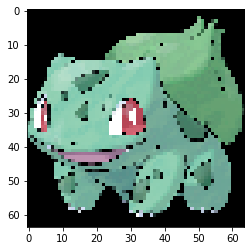

In [3]:
# Show a sample image from the dataset
# plt.imshow(iterator.get_next())

plt.imshow(image_dataset[0])

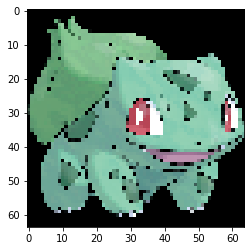

In [4]:
# Data Augmentation
# Creating new images by flipping/mirroring the existing images
# plt.imshow(np.fliplr(iterator.get_next()))

plt.imshow(image_dataset[1])

In [5]:
# flipped_images = []
# for image in image_dataset:
#   flipped_images.append(np.fliplr(image))

# flipped_image_dataset = tf.data.Dataset.from_tensor_slices(np.array(flipped_images))

In [6]:
# Combined image dataset (with flipped images)
# image_dataset = image_dataset.concatenate(flipped_image_dataset)

In [26]:
# Generator 

def generator(input_size):
    model = Sequential()
    
    model.add(Dense(4*4*512, activation="relu", input_shape=(input_size,)))
#     model.add(BatchNormalization())
#     model.add(LeakyReLU())
    model.add(Reshape((4, 4, 512)))
    
    model.add(Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(ReLU())
    
#     model.add(Conv2DTranspose(filters=3, kernel_size=(4, 4), padding='same', activation='tanh'))
    model.add(Conv2D(filters=3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    
    input = Input(shape=(input_size,))
    
    generated_image = model(input)
    
    return Model(input, generated_image)


In [27]:
# Generator model summary
generator_model = generator(100)
generator_model.layers[1].summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 8, 8, 512)         4194816   
_________________________________________________________________
batch_normalization_36 (Batc (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu_24 (ReLU)              (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 16, 16, 256)       2097408   
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 16, 256)      

In [28]:
# Discriminator 

def discriminator(image_shape):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=128, kernel_size=(4, 4), strides=(1, 1), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 1), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    input_image = Input(shape=image_shape)
    
    prediction = model(input_image)
    
    return Model(input_image, prediction)

In [29]:
optimizer = Adam(1.5e-4, 0.5)
discriminator_optimizer = Adam(1.5e-4, 0.5)

image_shape = (64, 64, 3)

discriminator_model = discriminator(image_shape)
discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# discriminator_model.trainable = False

seed_input_size = 100
random_input = Input(shape=(seed_input_size,))

generator_model = generator(seed_input_size)
generated_image = generator_model(random_input)

prediction = discriminator_model(generated_image)

combined_model = Model(random_input, prediction)
combined_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [24]:
# # Convert tensorflow dataset to numpy array
# images_numpy_array = list(tf.data.Dataset.as_numpy_iterator(image_dataset))
# images_numpy_array = np.array(images_numpy_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0
discriminator loss: [1.66223365 0.2890625 ] 
generator loss: [0.45818477869033813, 0.796875]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


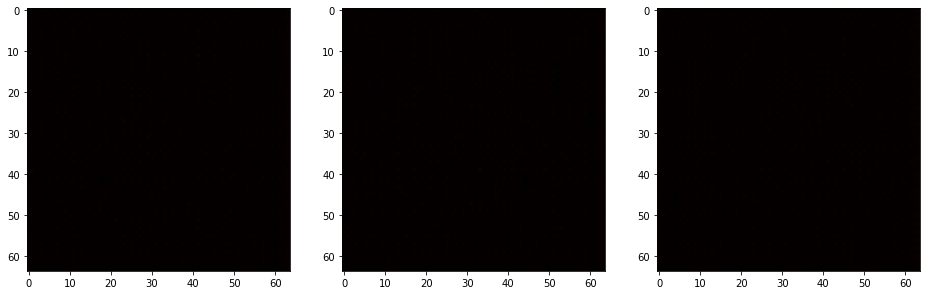

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 500
discriminator loss: [0.95975456 0.453125  ] 
generator loss: [0.5912950038909912, 0.71875]


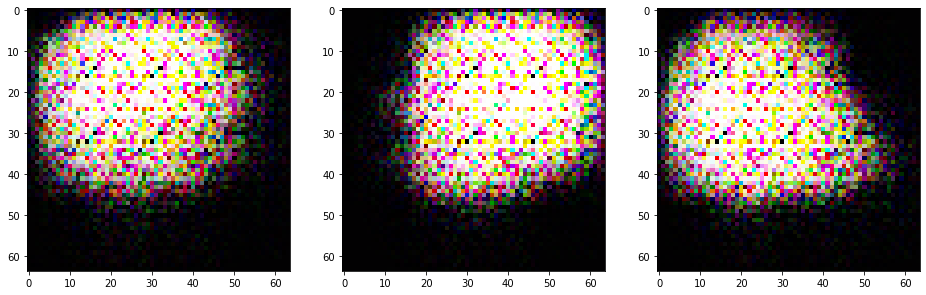

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1000
discriminator loss: [0.87064674 0.4921875 ] 
generator loss: [0.4899568557739258, 0.859375]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


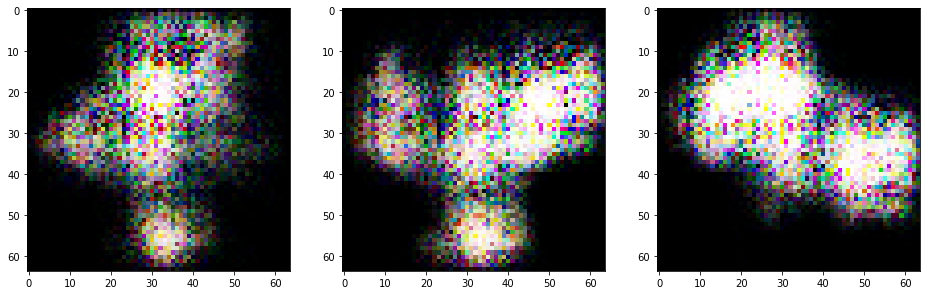

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1500
discriminator loss: [0.82732311 0.46875   ] 
generator loss: [0.4422149658203125, 0.96875]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


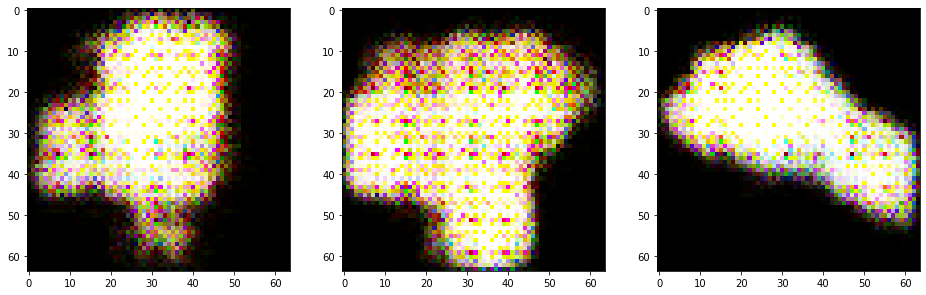

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2000
discriminator loss: [0.81358774 0.5       ] 
generator loss: [0.4622091054916382, 0.96875]


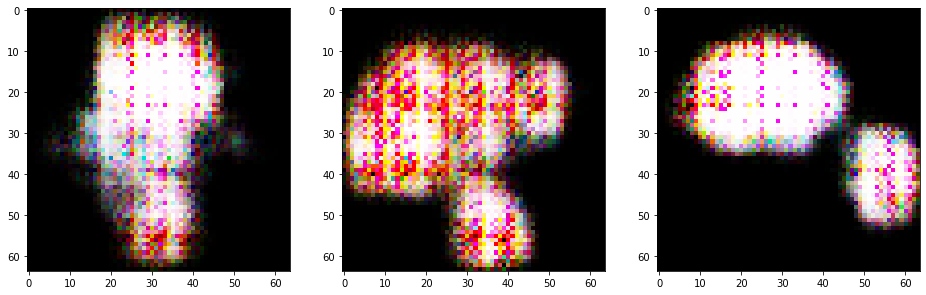

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2500
discriminator loss: [0.81753309 0.4921875 ] 
generator loss: [0.4825228452682495, 0.984375]


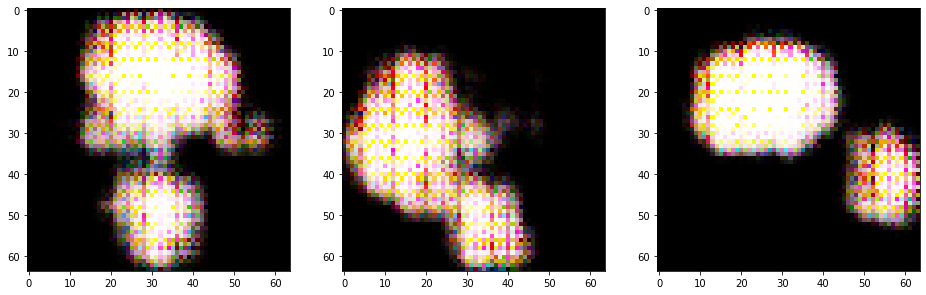

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3000
discriminator loss: [0.42783892 0.5703125 ] 
generator loss: [0.7859771251678467, 0.328125]


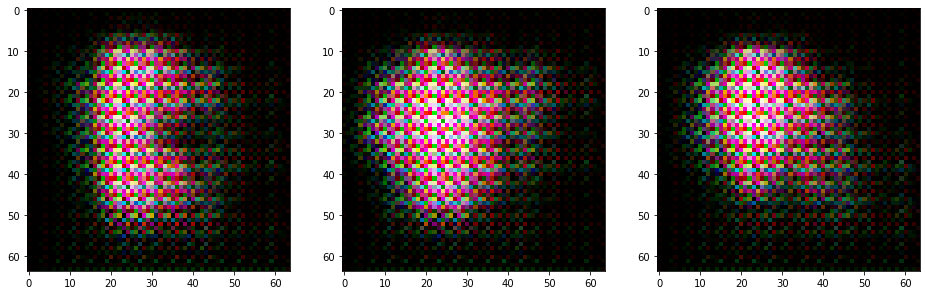

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3500
discriminator loss: [0.76435982 0.5       ] 
generator loss: [0.46143287420272827, 0.953125]


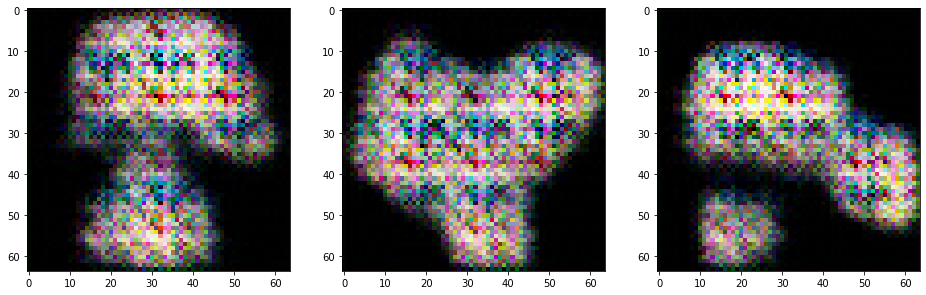

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4000
discriminator loss: [0.78097138 0.5       ] 
generator loss: [0.42972224950790405, 0.984375]


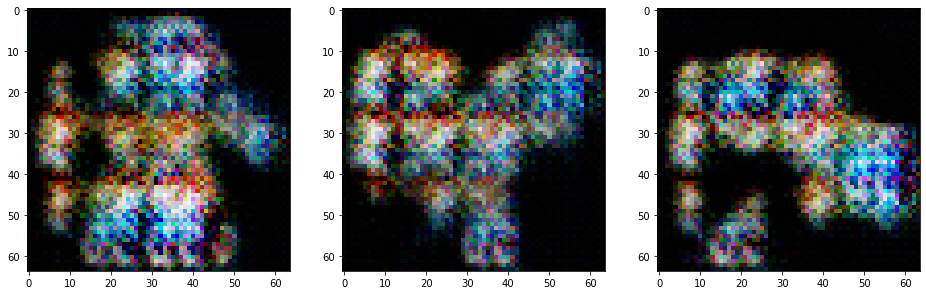

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4500
discriminator loss: [0.75206047 0.5078125 ] 
generator loss: [0.4526488780975342, 1.0]


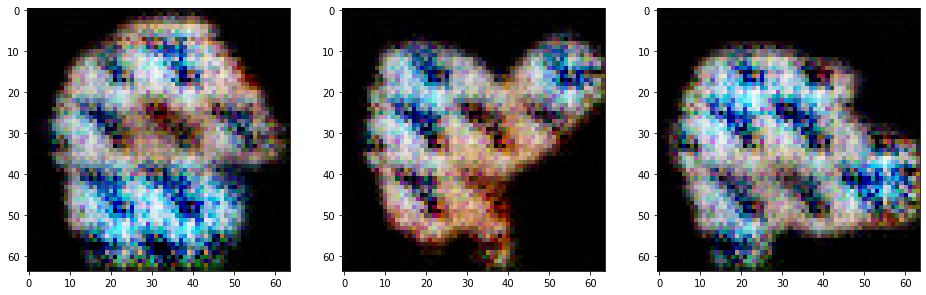

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5000
discriminator loss: [0.76150703 0.5       ] 
generator loss: [0.4494056701660156, 0.984375]


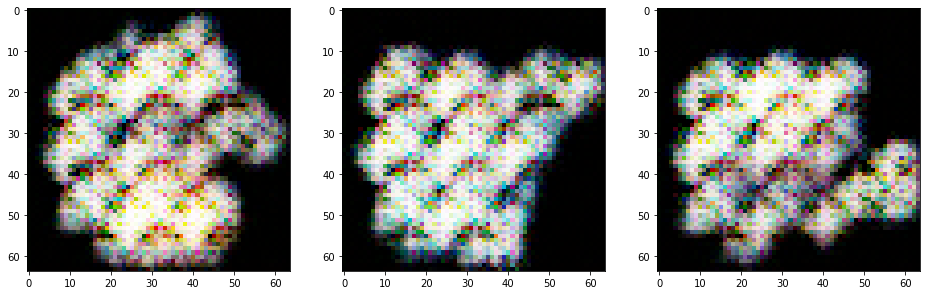

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5500
discriminator loss: [0.74355981 0.5078125 ] 
generator loss: [0.4473187327384949, 1.0]


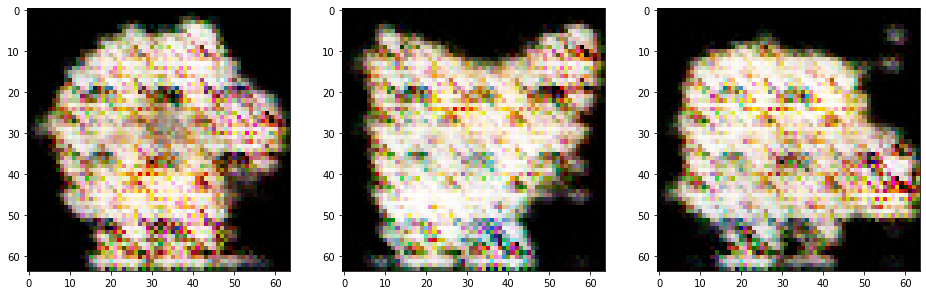

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6000
discriminator loss: [0.76127166 0.5       ] 
generator loss: [0.43082574009895325, 1.0]


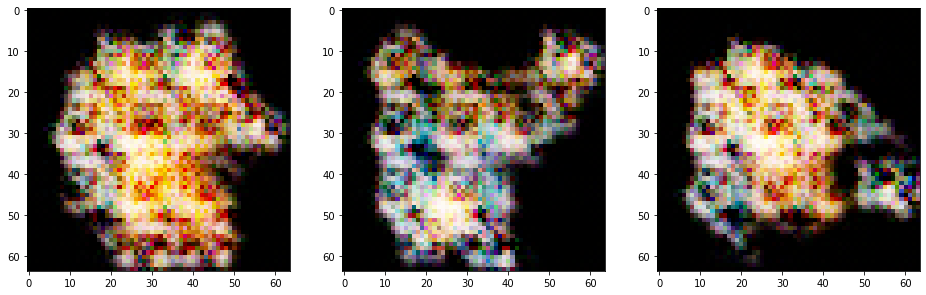

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6500
discriminator loss: [0.76582995 0.4921875 ] 
generator loss: [0.42663347721099854, 1.0]


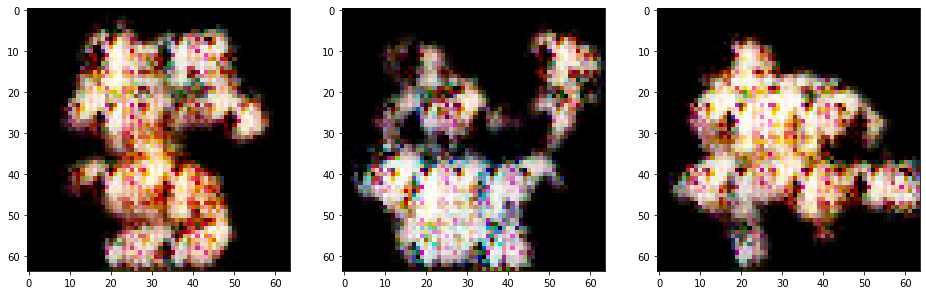

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7000
discriminator loss: [0.71655399 0.4921875 ] 
generator loss: [0.43250229954719543, 0.96875]


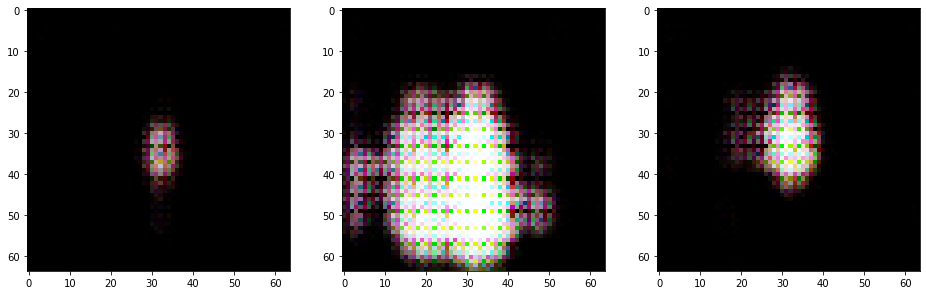

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7500
discriminator loss: [0.75003257 0.5       ] 
generator loss: [0.4234611690044403, 1.0]


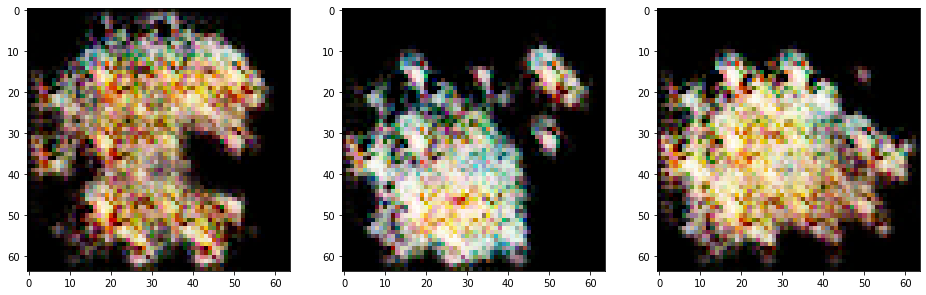

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8000
discriminator loss: [0.74946815 0.5       ] 
generator loss: [0.4216058552265167, 1.0]


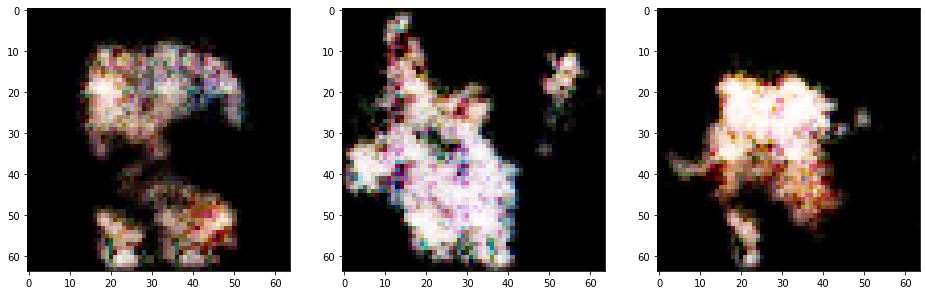

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8500
discriminator loss: [0.75277781 0.5       ] 
generator loss: [0.42138728499412537, 1.0]


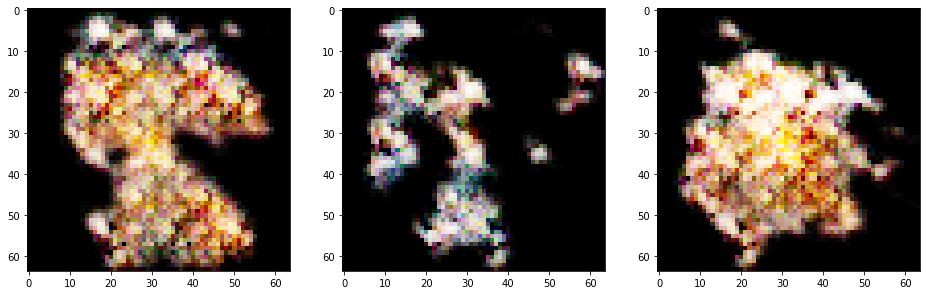

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9000
discriminator loss: [0.75279963 0.4921875 ] 
generator loss: [0.41582268476486206, 1.0]


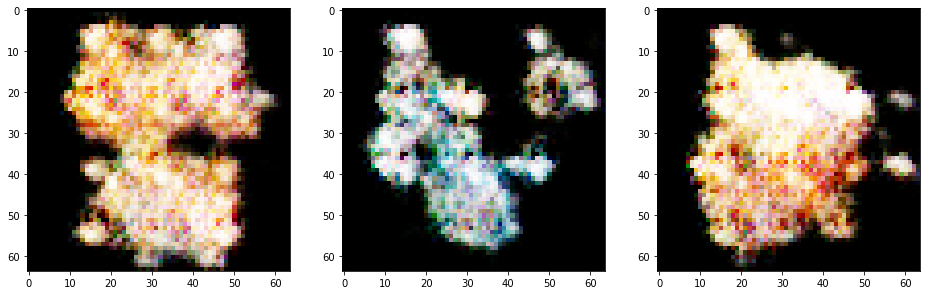

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9500
discriminator loss: [0.75355972 0.5       ] 
generator loss: [0.45689868927001953, 1.0]


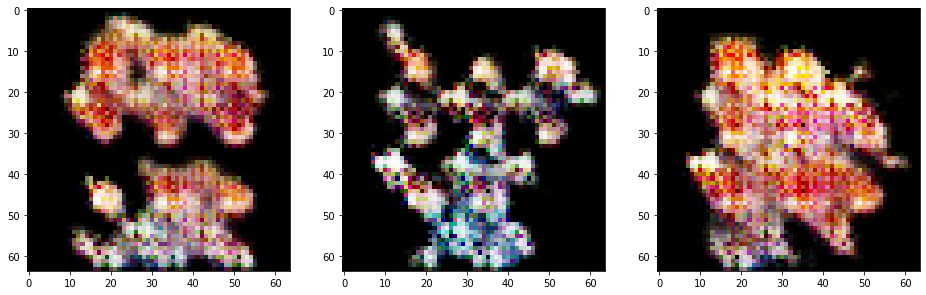

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 10000
discriminator loss: [0.85225397 0.3671875 ] 
generator loss: [0.25752824544906616, 1.0]


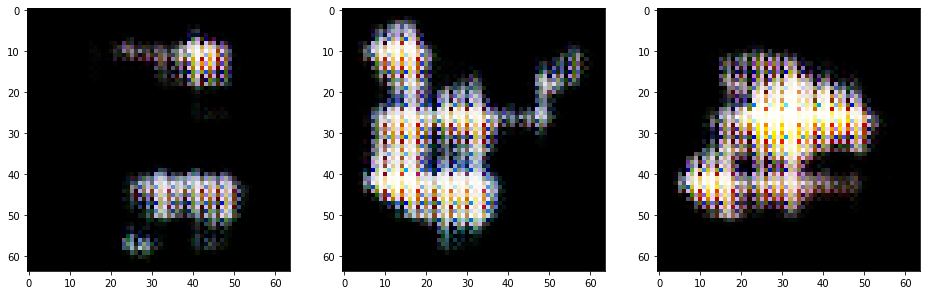

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 10500
discriminator loss: [0.75118086 0.5       ] 
generator loss: [0.4114011526107788, 1.0]


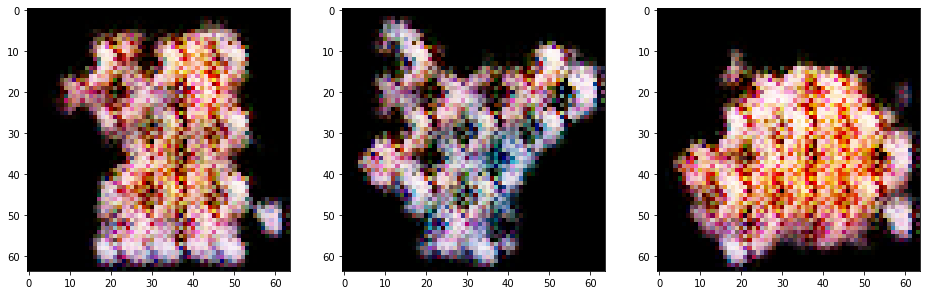

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 11000
discriminator loss: [0.76123202 0.5078125 ] 
generator loss: [0.39752495288848877, 1.0]


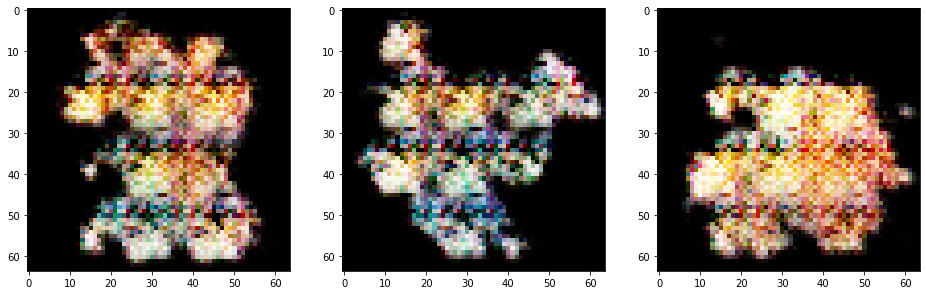

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 11500
discriminator loss: [1.34358189 0.4921875 ] 
generator loss: [0.412728488445282, 0.984375]


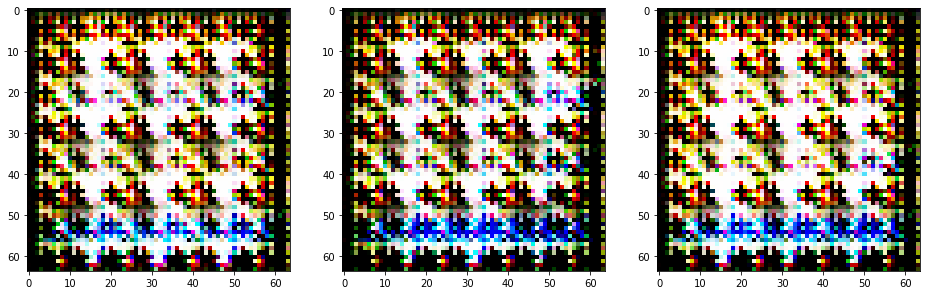

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 12000
discriminator loss: [0.76730292 0.5       ] 
generator loss: [0.40911126136779785, 1.0]


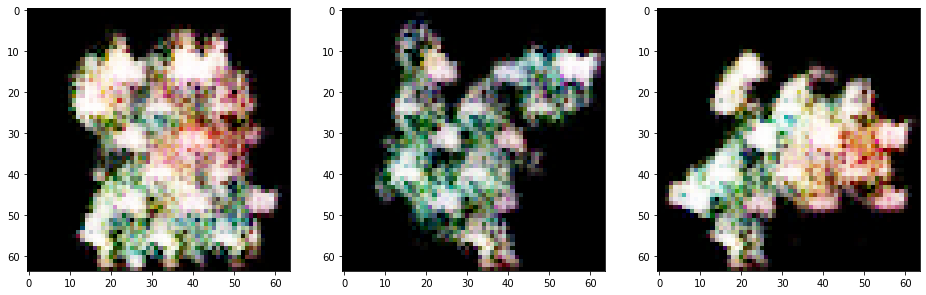

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 12500
discriminator loss: [0.72073457 0.5       ] 
generator loss: [0.4287841320037842, 1.0]


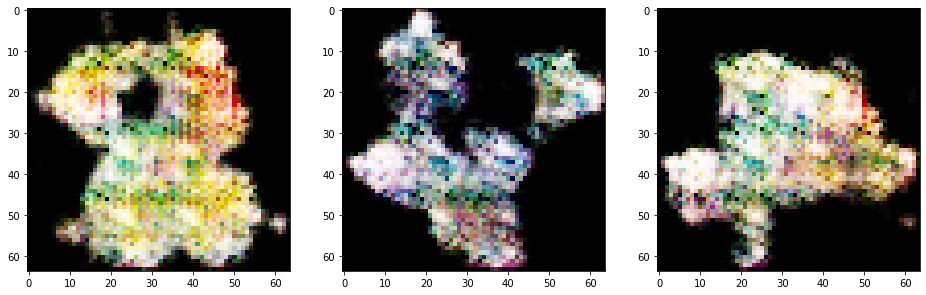

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 13000
discriminator loss: [0.74815756 0.5       ] 
generator loss: [0.4335198402404785, 1.0]


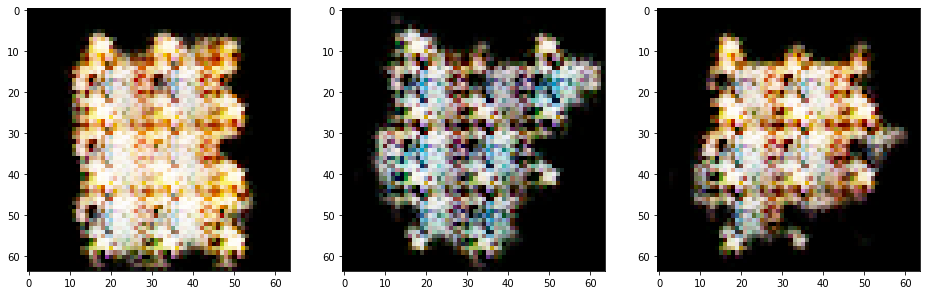

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 13500
discriminator loss: [0.76458767 0.5       ] 
generator loss: [0.4441079795360565, 1.0]


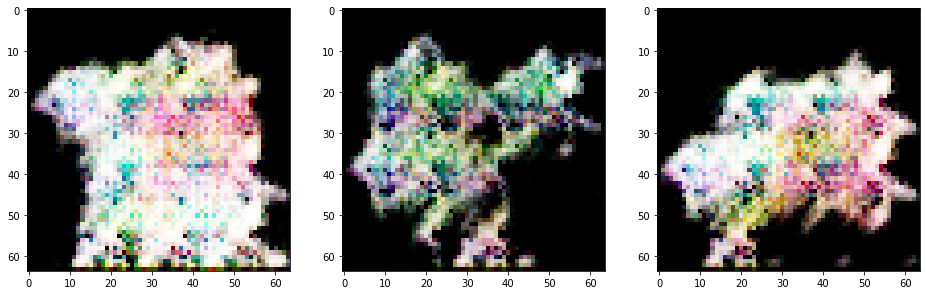

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 14000
discriminator loss: [0.76010138 0.5       ] 
generator loss: [0.42656272649765015, 1.0]


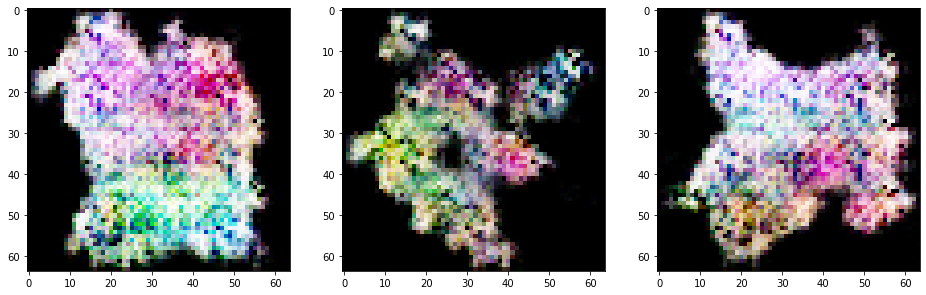

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 14500
discriminator loss: [0.75349373 0.5       ] 
generator loss: [0.4132705628871918, 1.0]


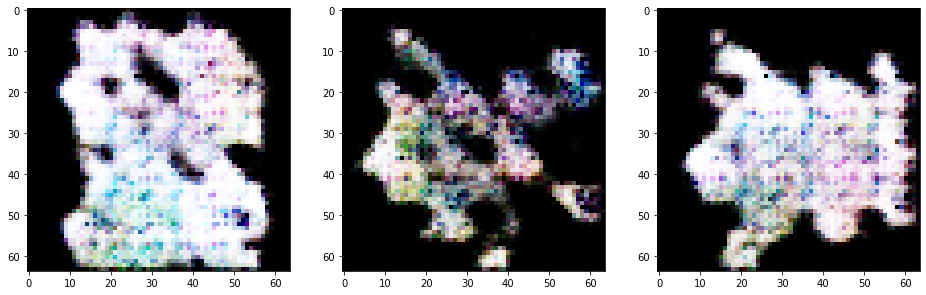

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15000
discriminator loss: [0.75656429 0.4921875 ] 
generator loss: [0.43132132291793823, 0.984375]


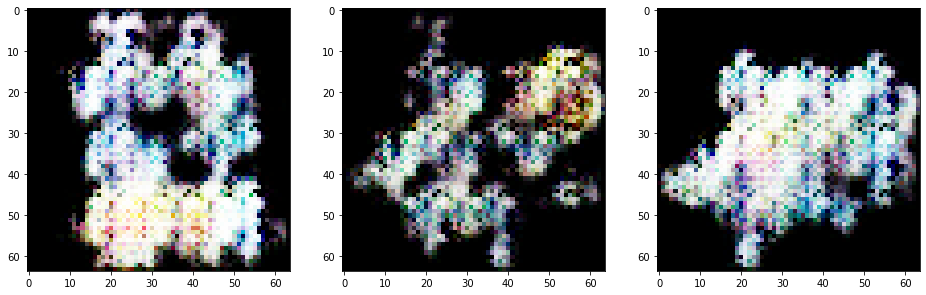

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15500
discriminator loss: [0.73691569 0.5       ] 
generator loss: [0.43269240856170654, 1.0]


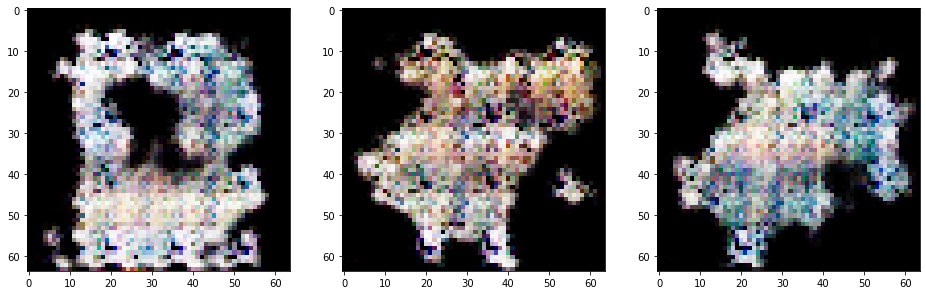

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 16000
discriminator loss: [0.73283574 0.5       ] 
generator loss: [0.4154946208000183, 1.0]


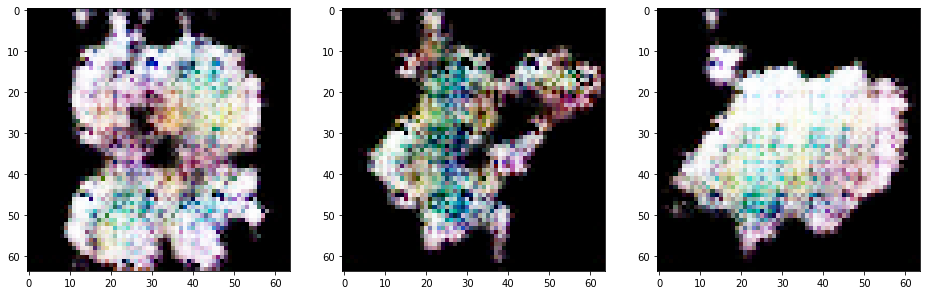

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 16500
discriminator loss: [0.76549402 0.5       ] 
generator loss: [0.4533576965332031, 0.984375]


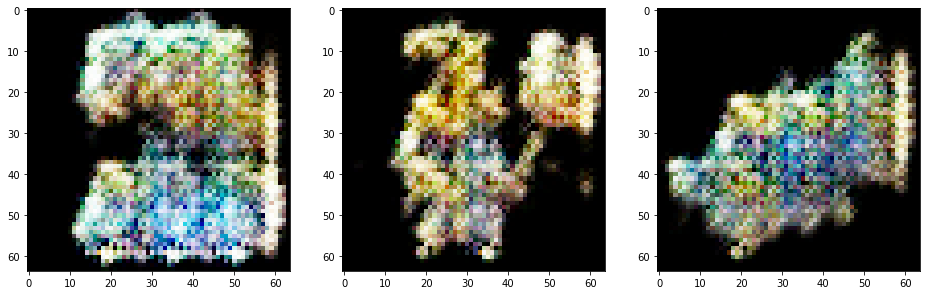

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 17000
discriminator loss: [0.7408224 0.5      ] 
generator loss: [0.41953831911087036, 1.0]


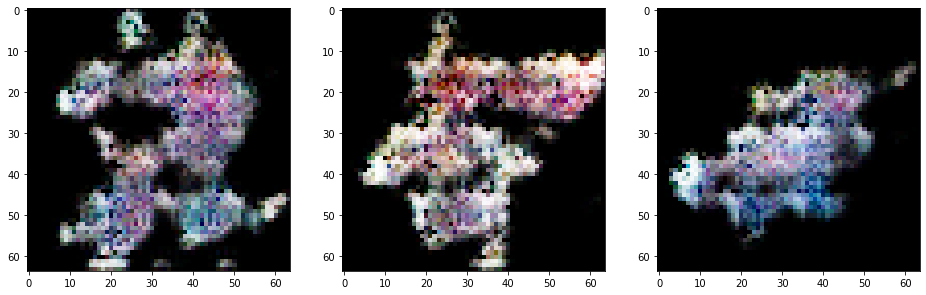

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 17500
discriminator loss: [0.74994084 0.4921875 ] 
generator loss: [0.41983163356781006, 1.0]


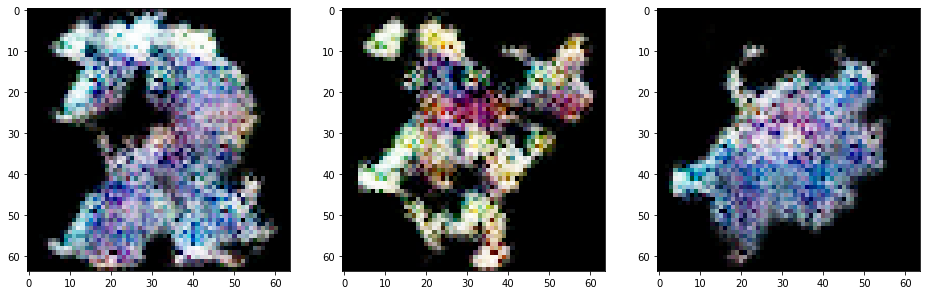

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 18000
discriminator loss: [0.7121006 0.5      ] 
generator loss: [0.4679238796234131, 0.984375]


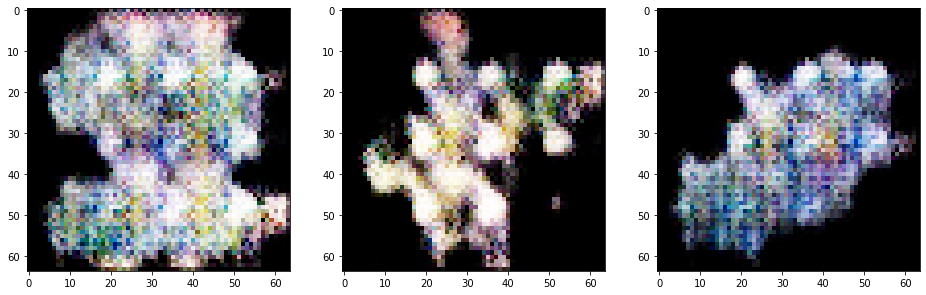

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 18500
discriminator loss: [0.68118551 0.5       ] 
generator loss: [0.42114025354385376, 1.0]


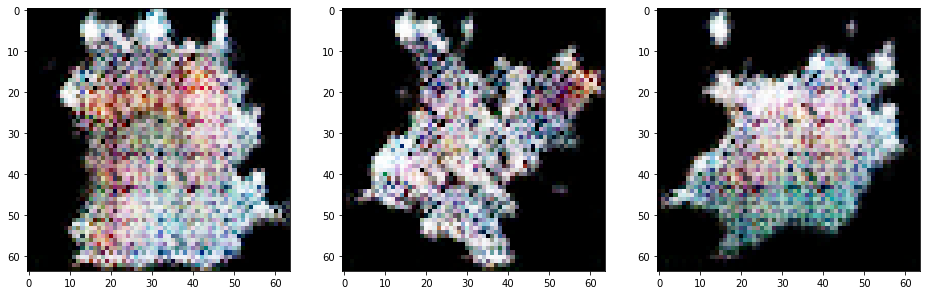

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 19000
discriminator loss: [0.7305719 0.5      ] 
generator loss: [0.43814343214035034, 0.984375]


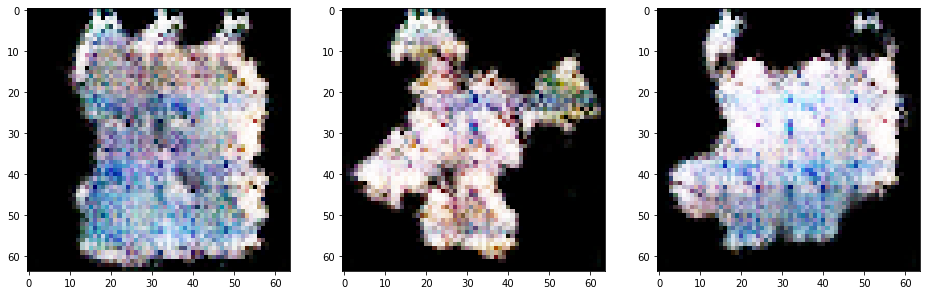

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 19500
discriminator loss: [0.74049288 0.5       ] 
generator loss: [0.4070091247558594, 1.0]


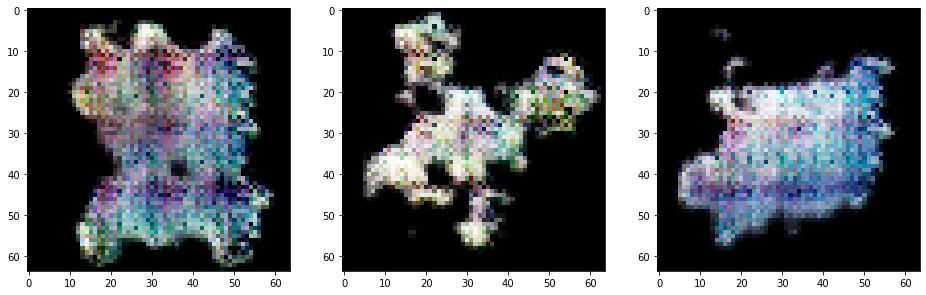

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20000
discriminator loss: [0.74265809 0.5       ] 
generator loss: [0.41579669713974, 0.984375]


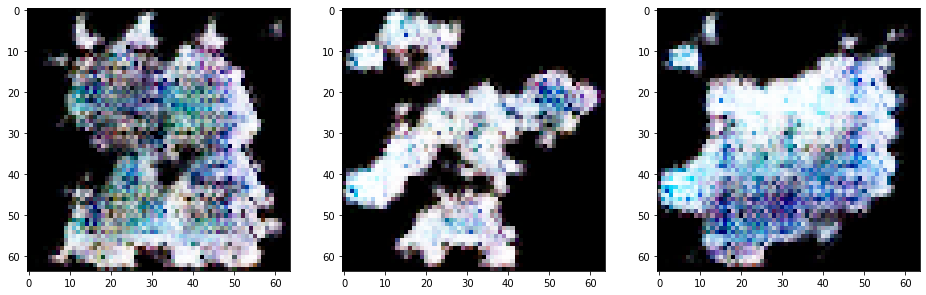

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20500
discriminator loss: [0.71710879 0.5       ] 
generator loss: [0.4596536159515381, 0.984375]


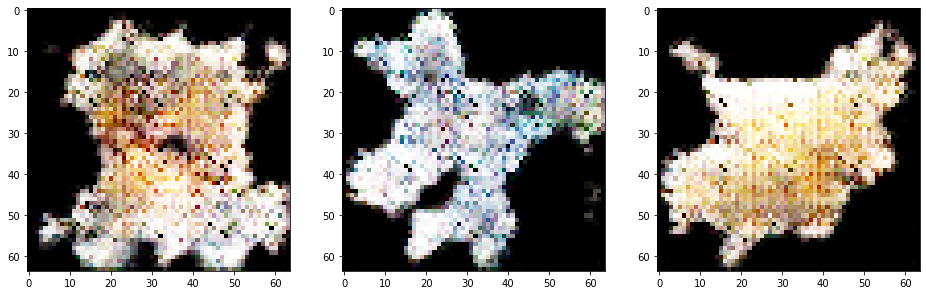

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 21000
discriminator loss: [0.77408403 0.5       ] 
generator loss: [0.43492114543914795, 0.984375]


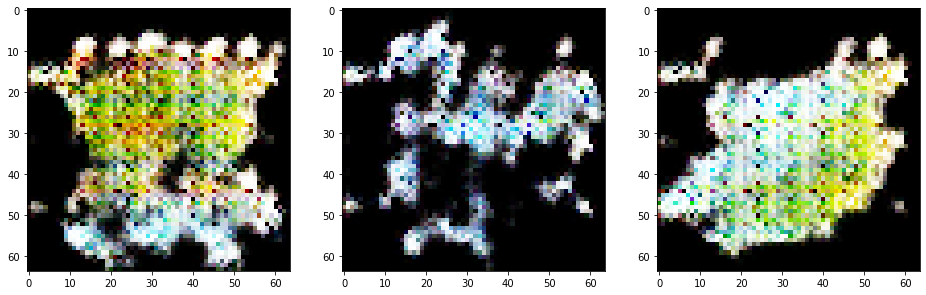

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 21500
discriminator loss: [0.70363012 0.5       ] 
generator loss: [0.4509629011154175, 0.9375]


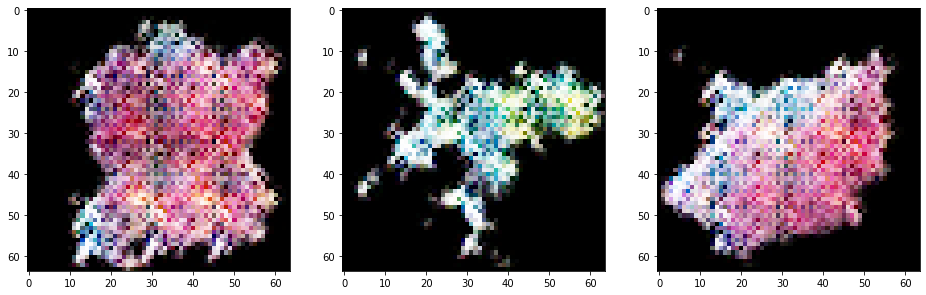

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 22000
discriminator loss: [0.70739403 0.5078125 ] 
generator loss: [0.47479796409606934, 0.9375]


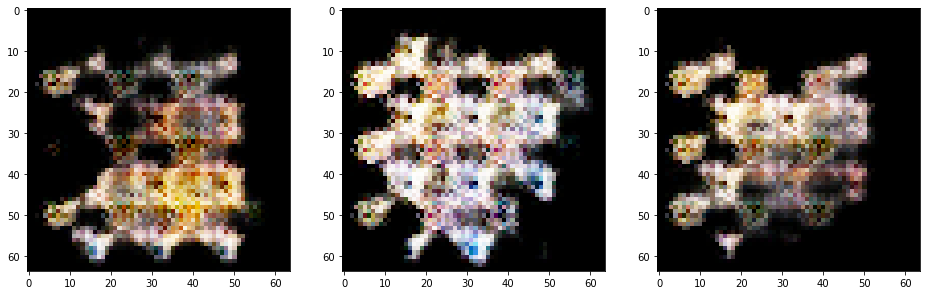

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 22500
discriminator loss: [0.67397034 0.5078125 ] 
generator loss: [0.48530980944633484, 0.9375]


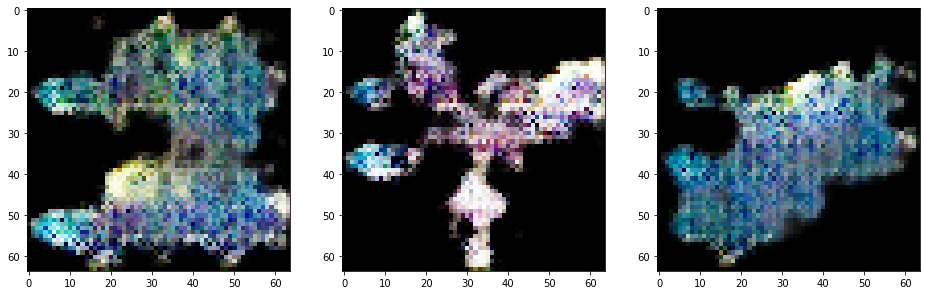

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 23000
discriminator loss: [0.70945749 0.5234375 ] 
generator loss: [0.43330925703048706, 1.0]


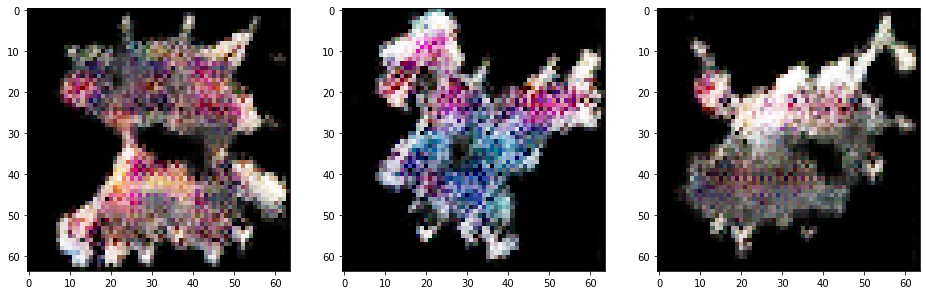

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 23500
discriminator loss: [0.75968538 0.5       ] 
generator loss: [0.36372047662734985, 1.0]


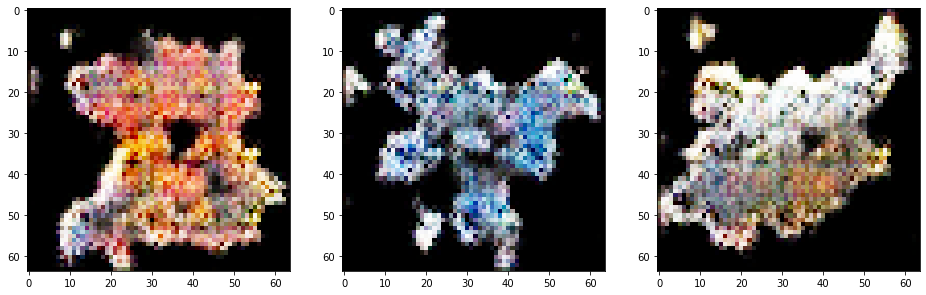

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 24000
discriminator loss: [0.68015018 0.515625  ] 
generator loss: [0.5885007381439209, 0.8125]


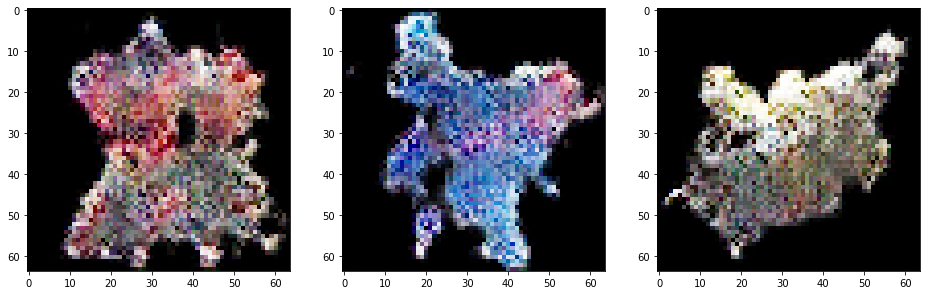

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 24500
discriminator loss: [0.76679224 0.5       ] 
generator loss: [0.5569406747817993, 0.859375]


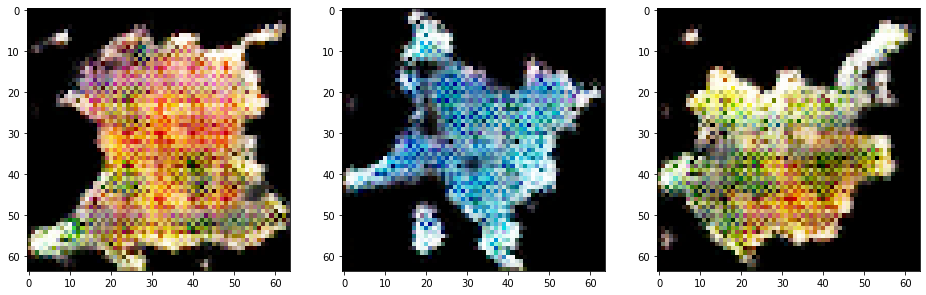

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 25000
discriminator loss: [0.51770183 0.6328125 ] 
generator loss: [0.4181860685348511, 0.90625]


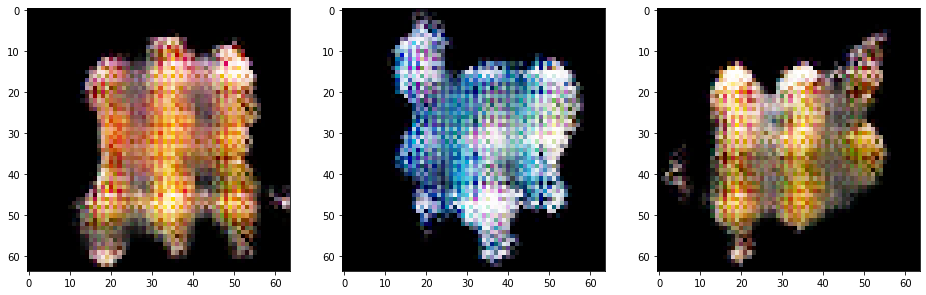

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 25500
discriminator loss: [0.70206445 0.5078125 ] 
generator loss: [0.4627615809440613, 0.984375]


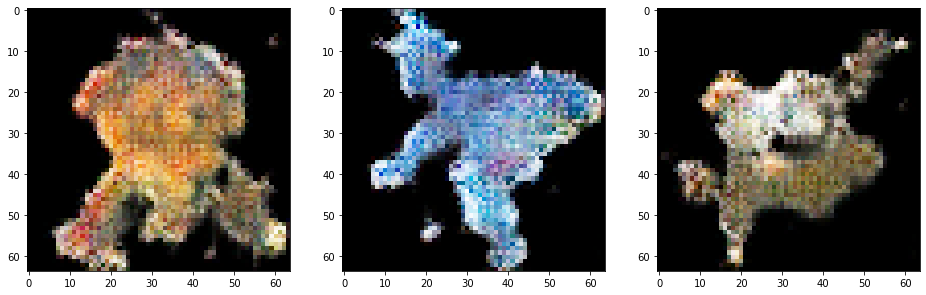

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 26000
discriminator loss: [0.54995329 0.5234375 ] 
generator loss: [0.5806127786636353, 0.875]


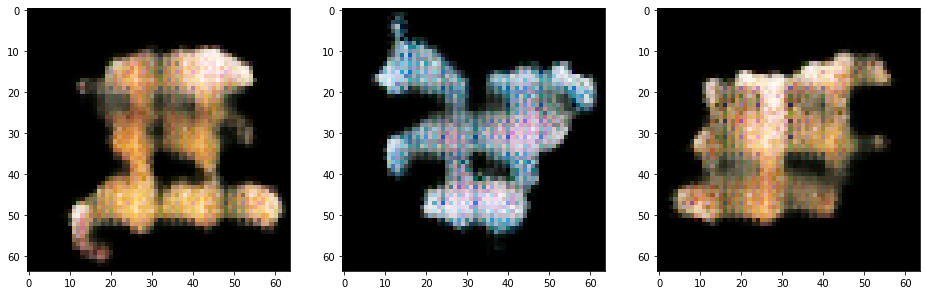

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 26500
discriminator loss: [0.7127701 0.5234375] 
generator loss: [0.4494090676307678, 0.921875]


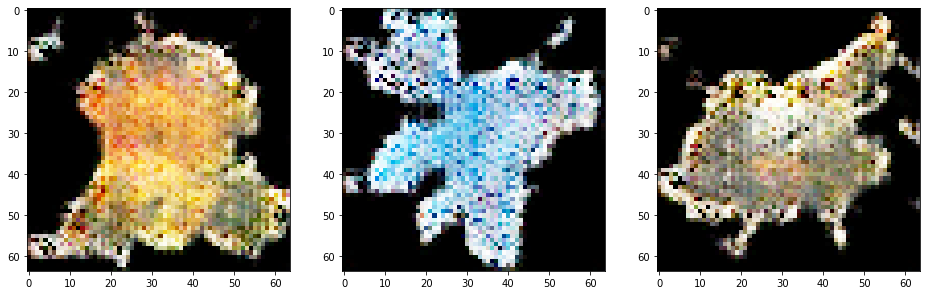

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 27000
discriminator loss: [1.27518767 0.3203125 ] 
generator loss: [0.2450733333826065, 0.984375]


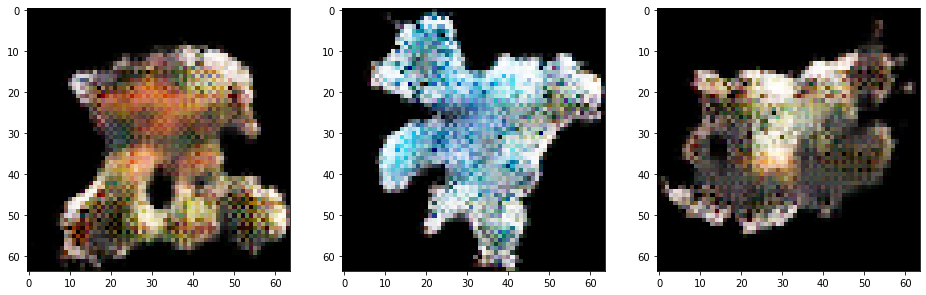

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 27500
discriminator loss: [0.72015002 0.5078125 ] 
generator loss: [0.4061577320098877, 0.984375]


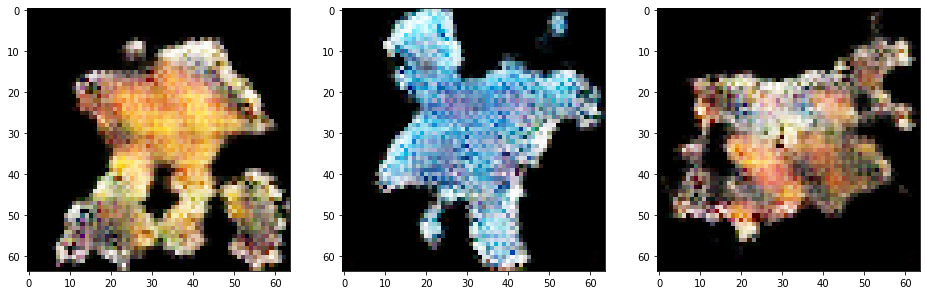

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 28000
discriminator loss: [1.11412424 0.2734375 ] 
generator loss: [0.38517215847969055, 1.0]


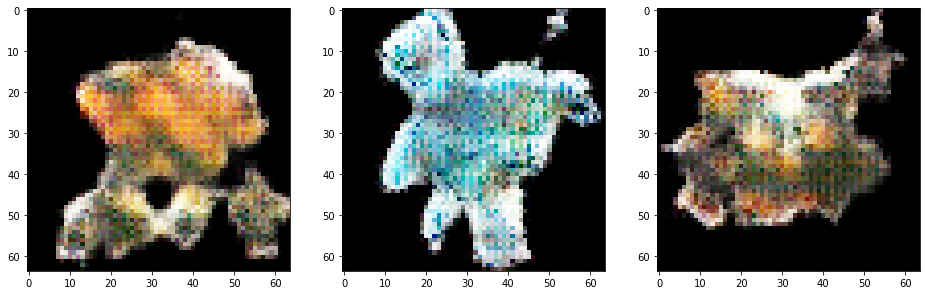

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 28500
discriminator loss: [0.70649023 0.5       ] 
generator loss: [0.46614164113998413, 1.0]


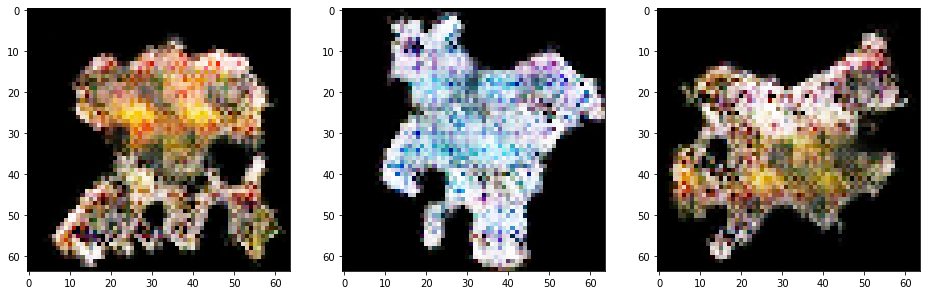

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 29000
discriminator loss: [0.73071477 0.5       ] 
generator loss: [0.4145662188529968, 1.0]


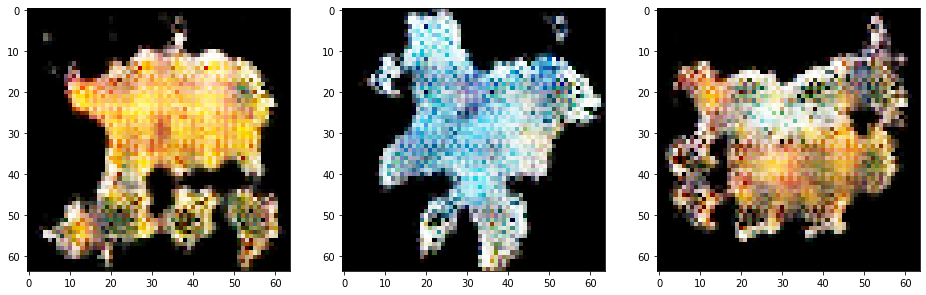

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 29500
discriminator loss: [0.72295743 0.5       ] 
generator loss: [0.48910439014434814, 0.953125]


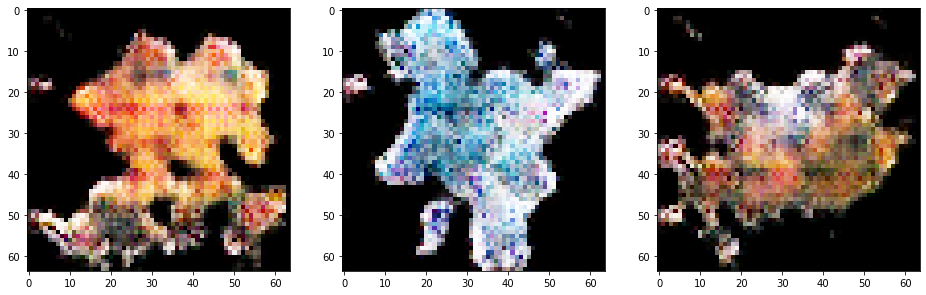

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 30000
discriminator loss: [0.75261113 0.5078125 ] 
generator loss: [0.464092493057251, 0.953125]


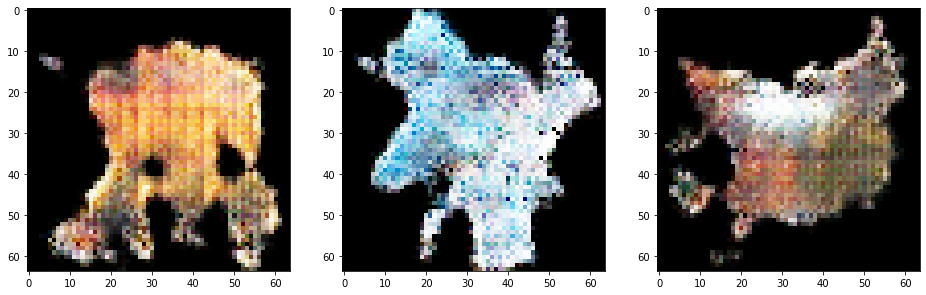

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 30500
discriminator loss: [0.65800421 0.5       ] 
generator loss: [0.33994948863983154, 0.953125]


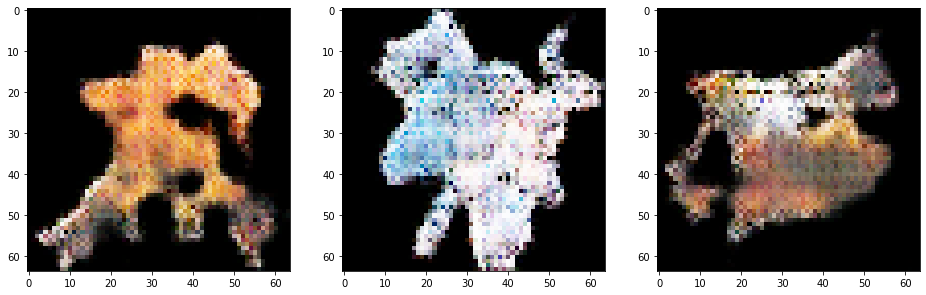

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 31000
discriminator loss: [0.7955474 0.453125 ] 
generator loss: [0.3922474980354309, 0.984375]


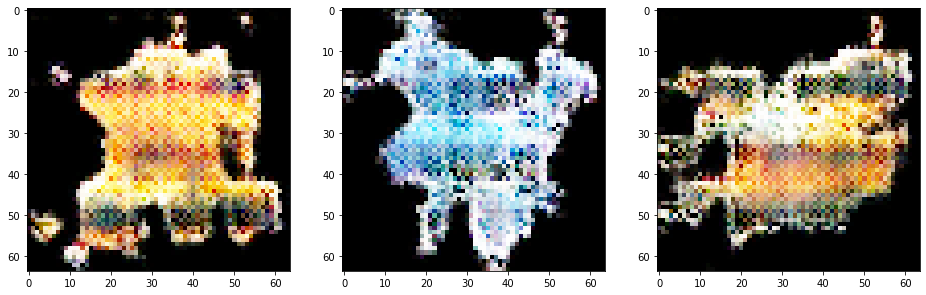

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 31500
discriminator loss: [0.69207597 0.515625  ] 
generator loss: [0.5315453410148621, 0.921875]


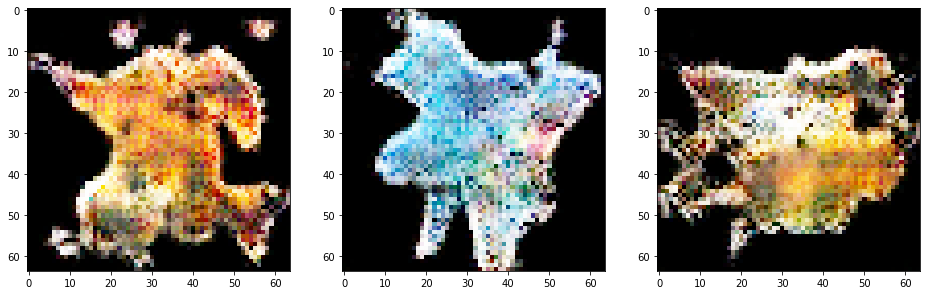

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 32000
discriminator loss: [0.68600698 0.5       ] 
generator loss: [0.45102518796920776, 0.953125]


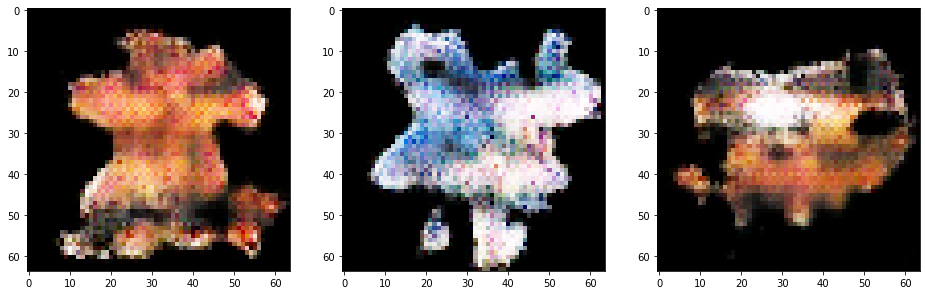

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 32500
discriminator loss: [0.97260308 0.3671875 ] 
generator loss: [0.2890399098396301, 1.0]


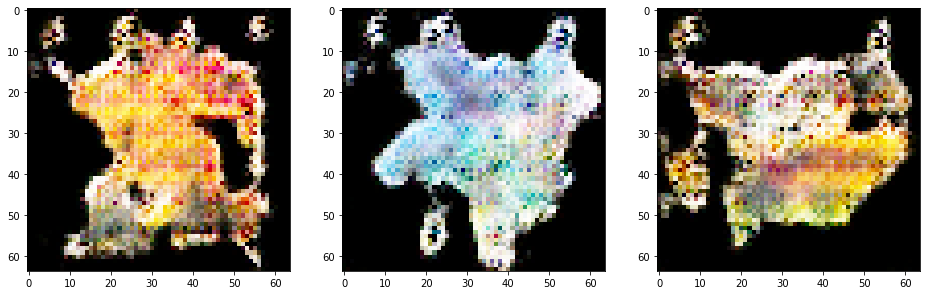

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 33000
discriminator loss: [0.70149386 0.515625  ] 
generator loss: [0.4760448634624481, 0.953125]


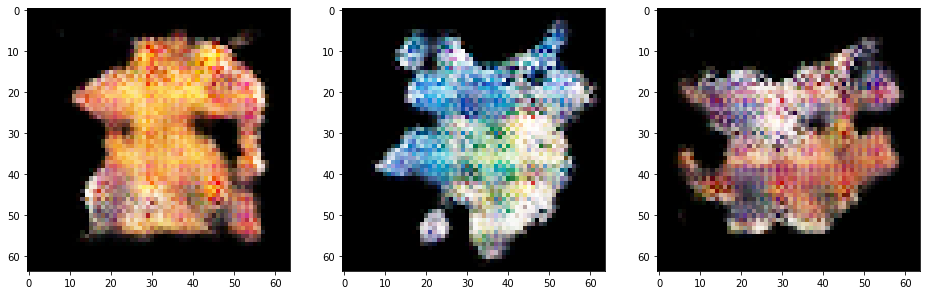

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 33500
discriminator loss: [0.68820286 0.5234375 ] 
generator loss: [0.5663822293281555, 0.828125]


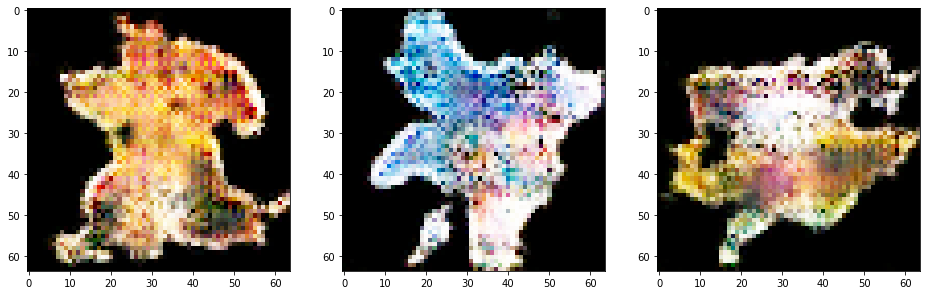

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 34000
discriminator loss: [0.72350392 0.515625  ] 
generator loss: [0.45885053277015686, 0.953125]


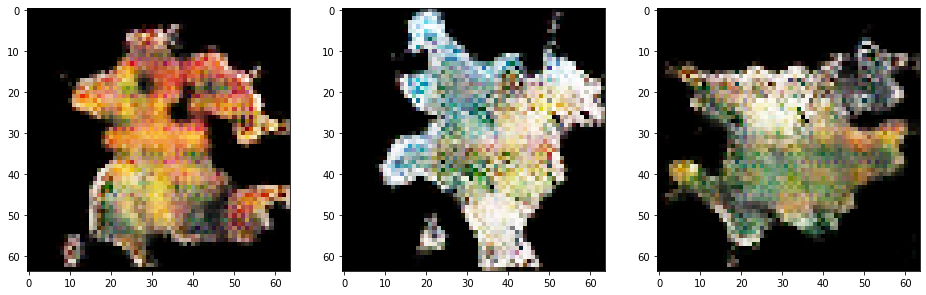

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 34500
discriminator loss: [0.72778079 0.5234375 ] 
generator loss: [0.43629324436187744, 0.96875]


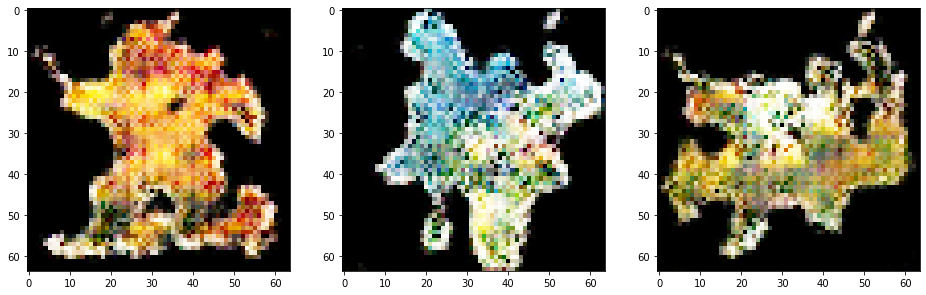

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 35000
discriminator loss: [0.7245924 0.5      ] 
generator loss: [0.3588027060031891, 0.984375]


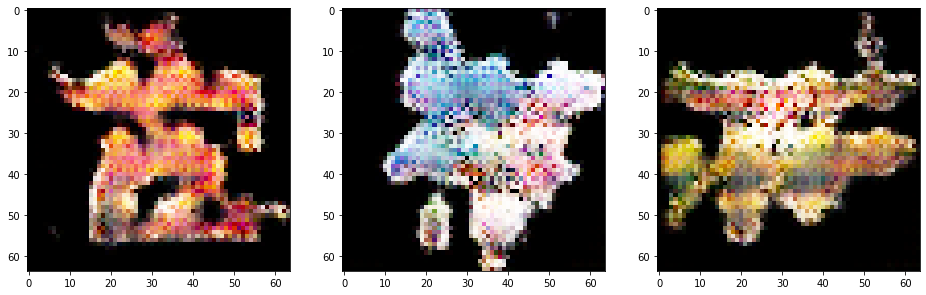

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 35500
discriminator loss: [0.66345456 0.5       ] 
generator loss: [0.4373193383216858, 0.984375]


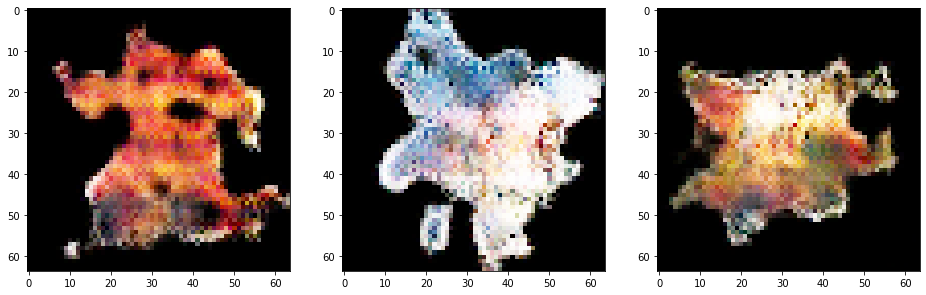

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 36000
discriminator loss: [0.67512104 0.5078125 ] 
generator loss: [0.5762381553649902, 0.8125]


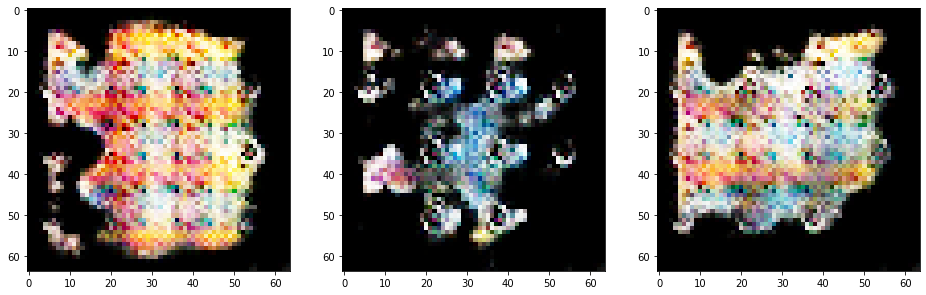

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 36500
discriminator loss: [0.84635535 0.515625  ] 
generator loss: [0.6249305009841919, 0.640625]


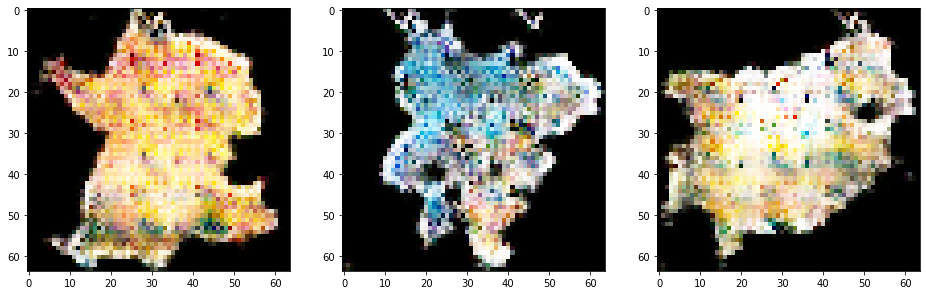

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 37000
discriminator loss: [0.55198631 0.6640625 ] 
generator loss: [0.7792792916297913, 0.40625]


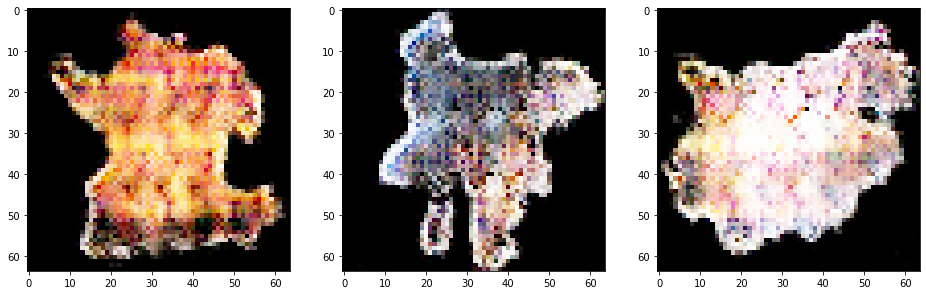

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 37500
discriminator loss: [0.66805696 0.5       ] 
generator loss: [0.4082232117652893, 1.0]


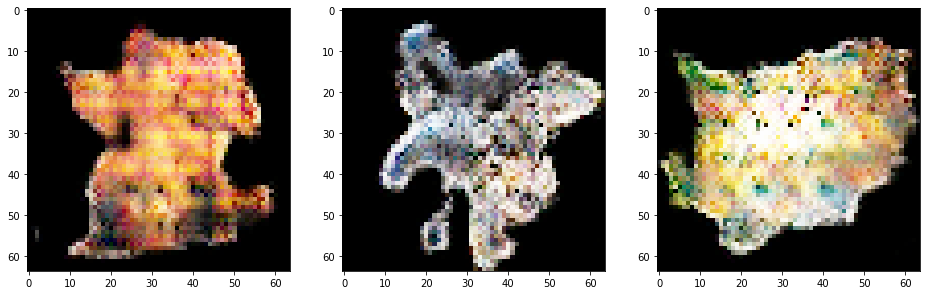

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 38000
discriminator loss: [0.54797776 0.546875  ] 
generator loss: [0.47650566697120667, 0.9375]


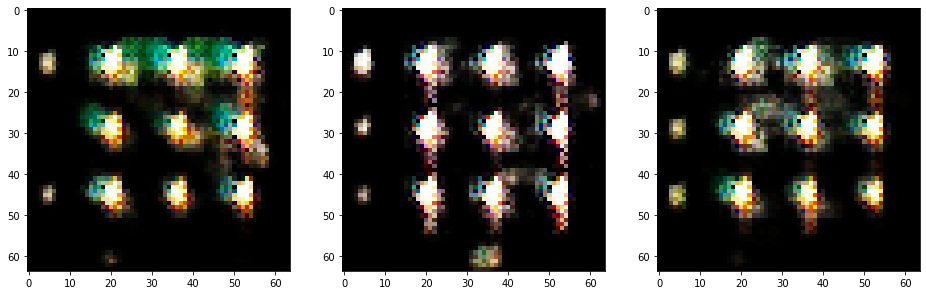

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 38500
discriminator loss: [0.57954799 0.6640625 ] 
generator loss: [0.62093186378479, 0.75]


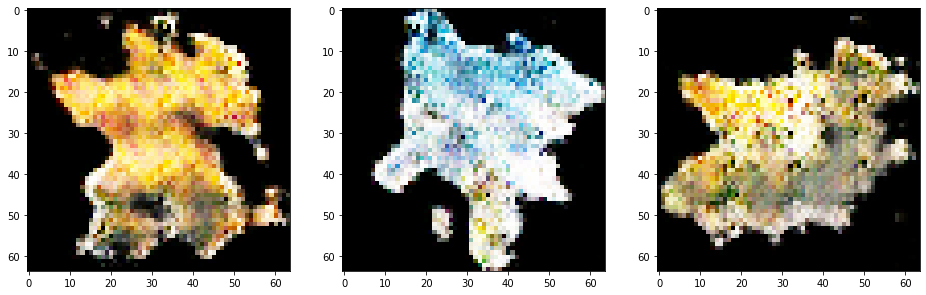

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 39000
discriminator loss: [0.60653442 0.5625    ] 
generator loss: [0.3042501211166382, 1.0]


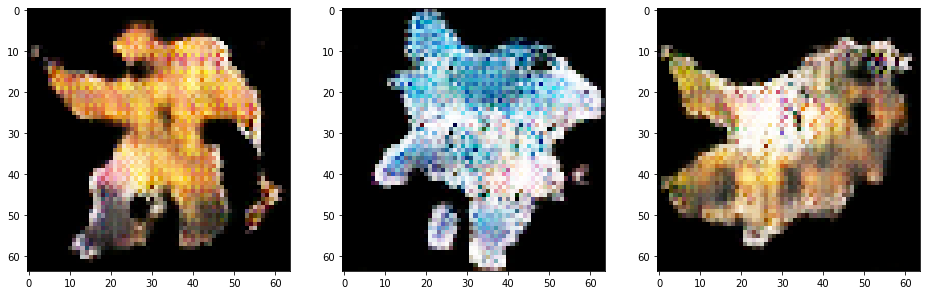

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 39500
discriminator loss: [0.79568049 0.5078125 ] 
generator loss: [0.35725751519203186, 0.984375]


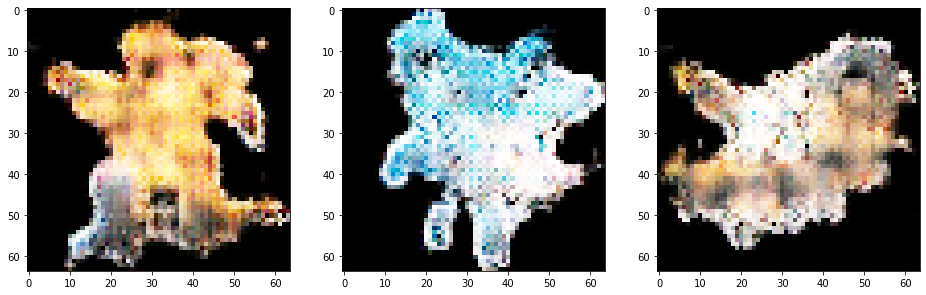

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 40000
discriminator loss: [0.69688565 0.5234375 ] 
generator loss: [0.468625009059906, 0.90625]


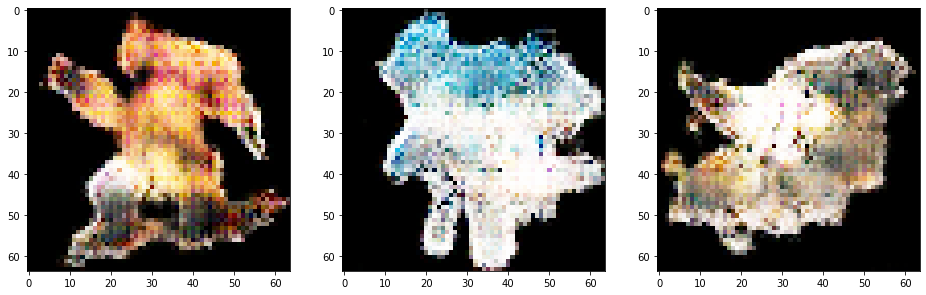

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 40500
discriminator loss: [0.67860073 0.53125   ] 
generator loss: [0.40345385670661926, 1.0]


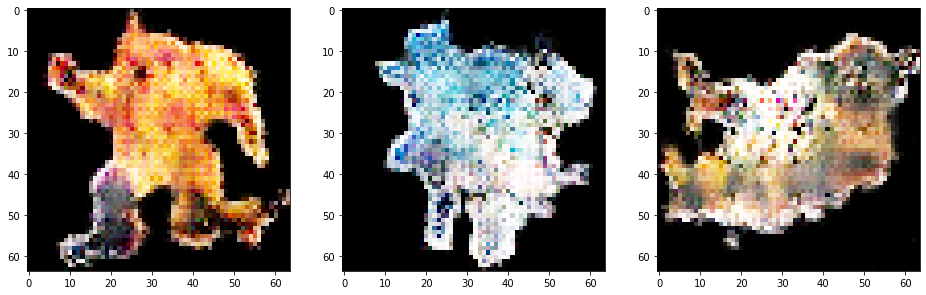

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 41000
discriminator loss: [0.44145623 0.8125    ] 
generator loss: [0.3530309498310089, 1.0]


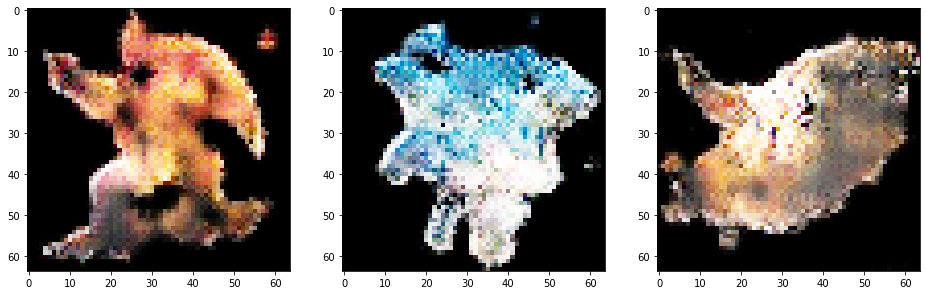

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 41500
discriminator loss: [0.53151079 0.6796875 ] 
generator loss: [0.8050812482833862, 0.3125]


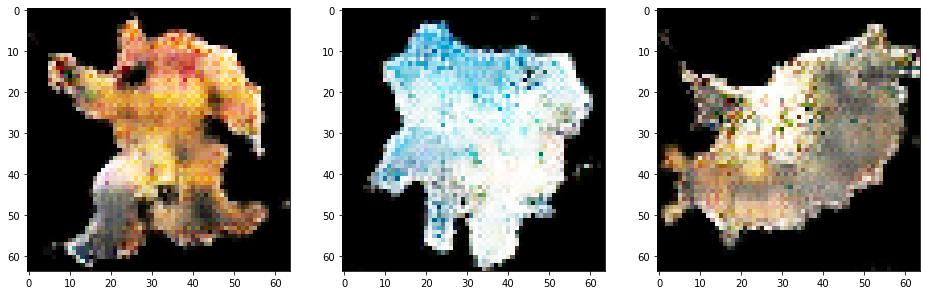

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 42000
discriminator loss: [0.49047378 0.8359375 ] 
generator loss: [0.3553178906440735, 0.953125]


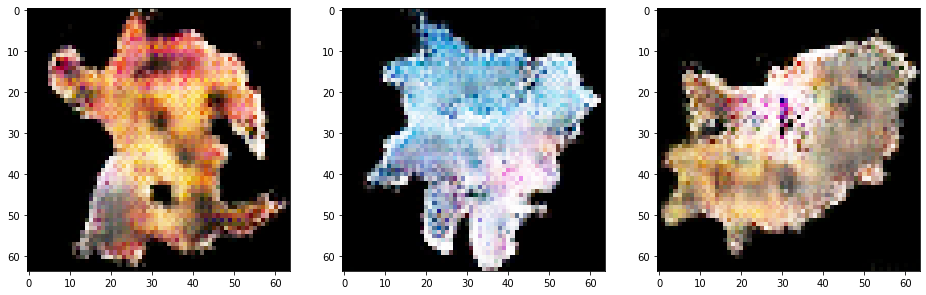

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 42500
discriminator loss: [0.65079466 0.5       ] 
generator loss: [0.4332452416419983, 0.953125]


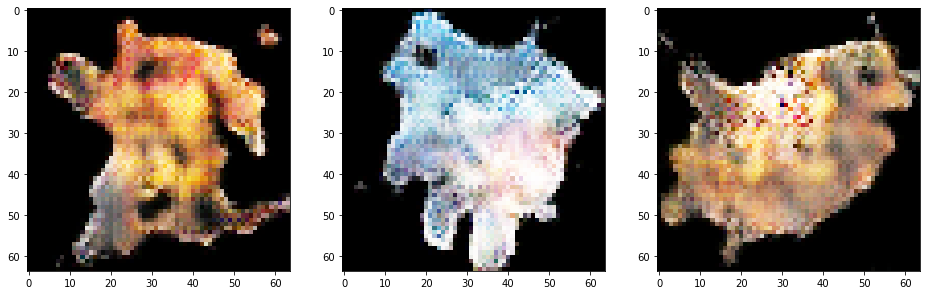

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 43000
discriminator loss: [0.60800827 0.5546875 ] 
generator loss: [0.4559401273727417, 0.96875]


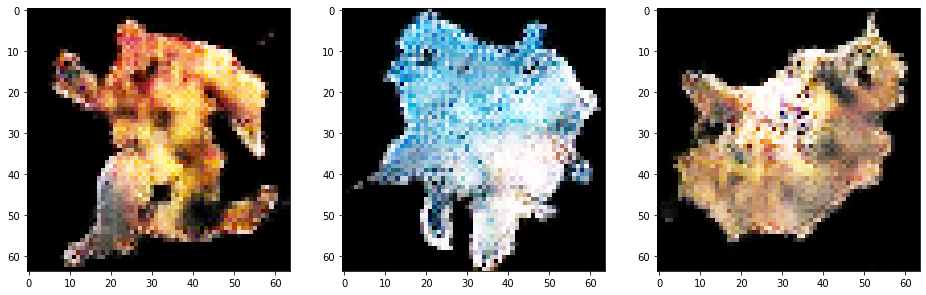

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 43500
discriminator loss: [0.75075534 0.5078125 ] 
generator loss: [0.5057240128517151, 0.84375]


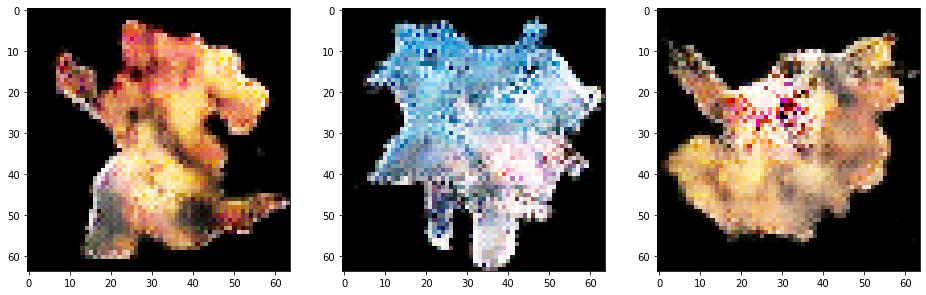

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 44000
discriminator loss: [0.40596128 0.9140625 ] 
generator loss: [0.4140819013118744, 0.984375]


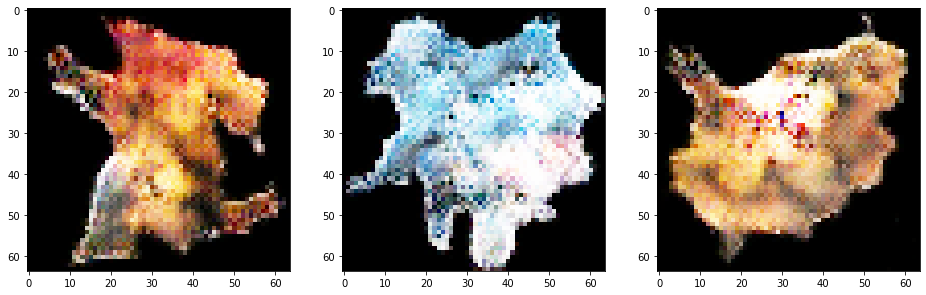

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 44500
discriminator loss: [0.6938367 0.5078125] 
generator loss: [0.461955726146698, 0.953125]


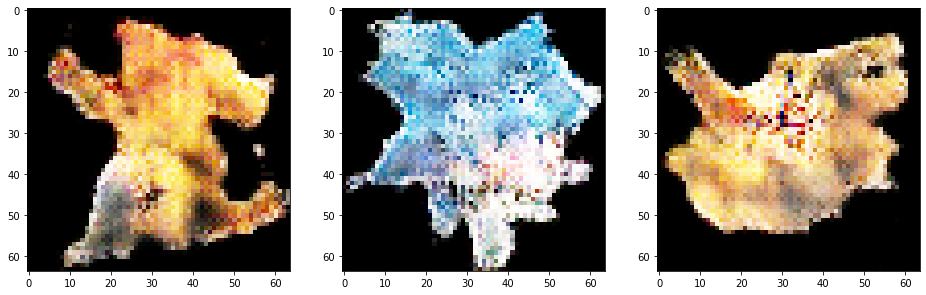

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 45000
discriminator loss: [0.56369762 0.609375  ] 
generator loss: [0.5366227030754089, 0.859375]


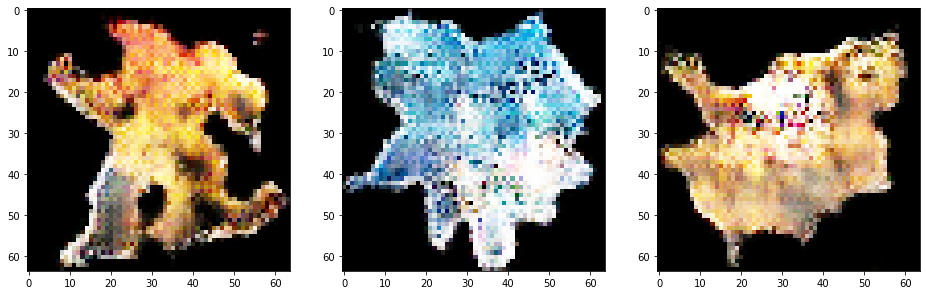

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 45500
discriminator loss: [0.60234326 0.5703125 ] 
generator loss: [0.2862946391105652, 1.0]


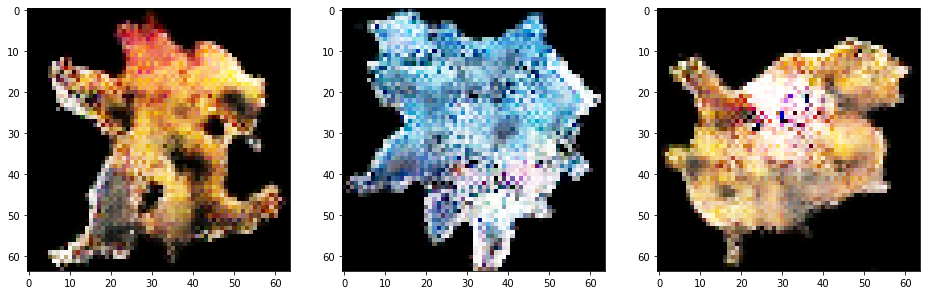

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 46000
discriminator loss: [0.76545165 0.5       ] 
generator loss: [0.4288599193096161, 1.0]


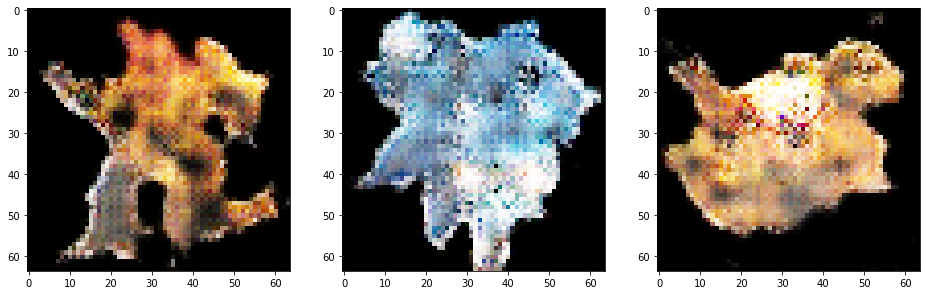

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 46500
discriminator loss: [0.57915301 0.5859375 ] 
generator loss: [0.43674948811531067, 0.96875]


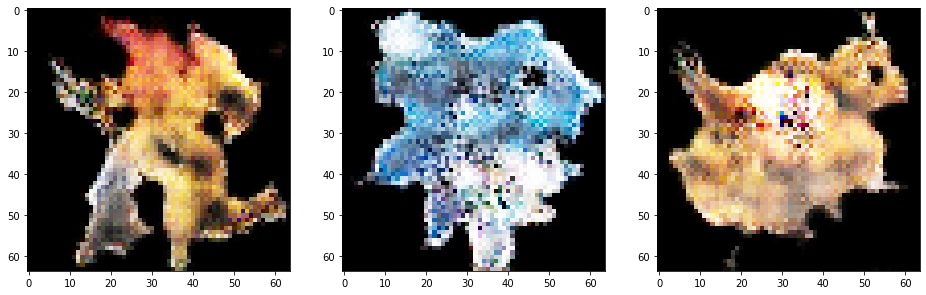

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 47000
discriminator loss: [0.71824718 0.5078125 ] 
generator loss: [0.5992143154144287, 0.75]


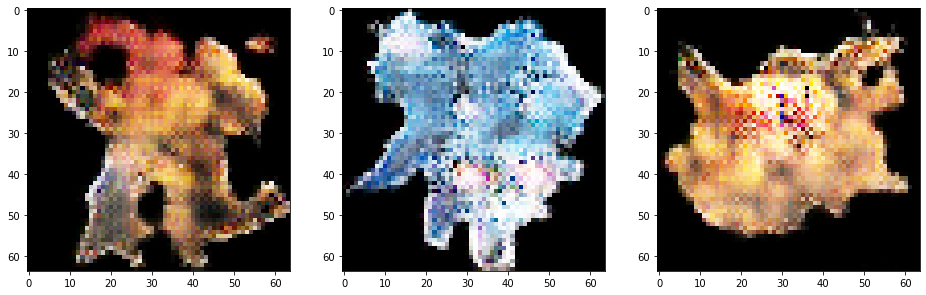

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 47500
discriminator loss: [0.57061633 0.6875    ] 
generator loss: [0.34575292468070984, 0.96875]


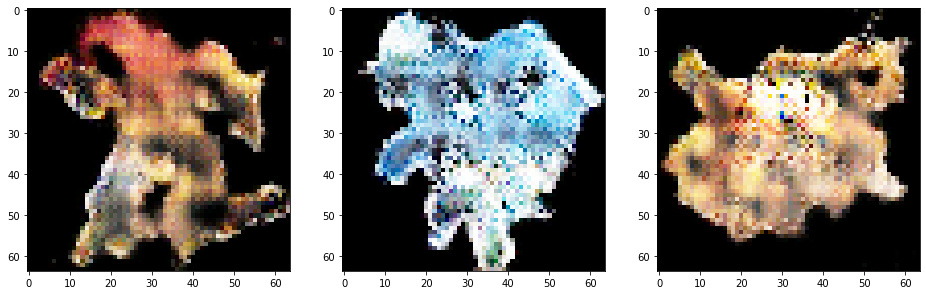

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 48000
discriminator loss: [0.98592129 0.25      ] 
generator loss: [0.4087739586830139, 0.9375]


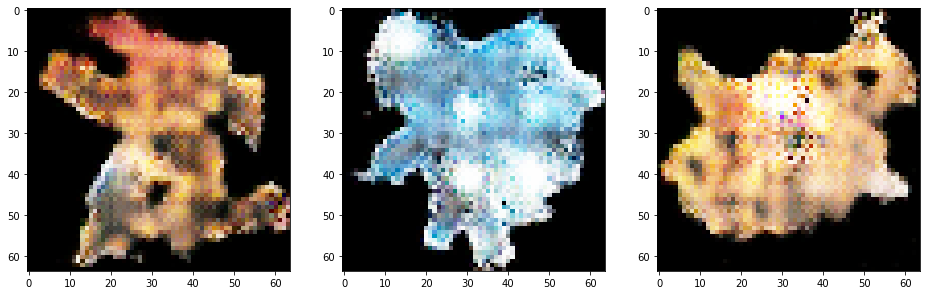

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 48500
discriminator loss: [0.74127036 0.5234375 ] 
generator loss: [0.500365674495697, 0.921875]


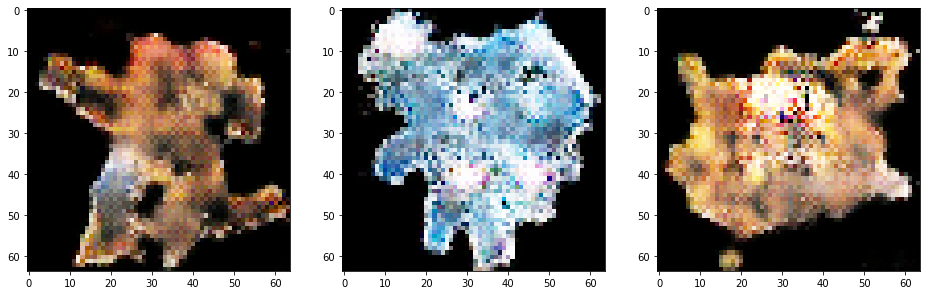

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 49000
discriminator loss: [0.68713896 0.5234375 ] 
generator loss: [0.4599756598472595, 0.953125]


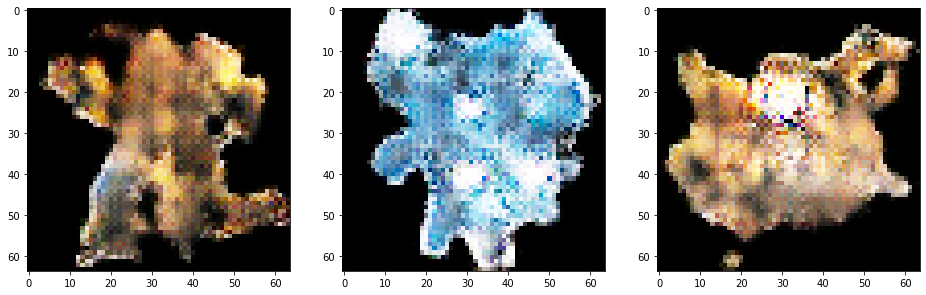

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 49500
discriminator loss: [0.67358459 0.515625  ] 
generator loss: [0.38064324855804443, 0.96875]


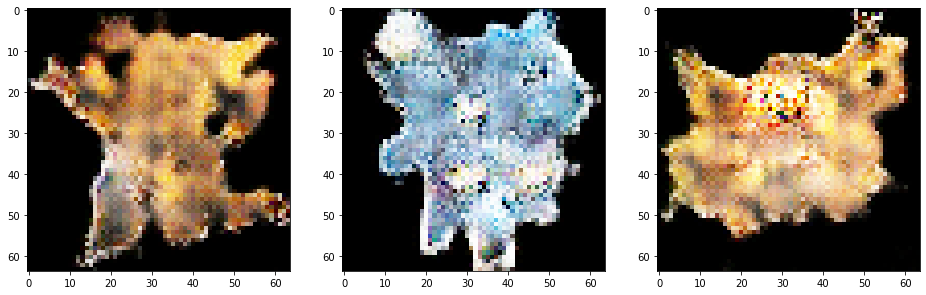

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 50000
discriminator loss: [0.92021829 0.4765625 ] 
generator loss: [0.4016658067703247, 0.984375]


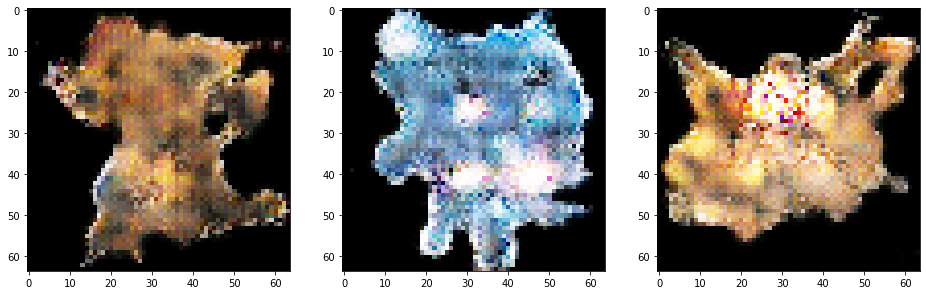

In [30]:
# Training Loop 
EPOCHS = 50001
BATCH_SIZE = 64

num_generated_images = 3
fixed_seeds = np.random.normal(0, 1, (num_generated_images, seed_input_size))

y_real = np.ones((BATCH_SIZE, 1))
y_fake = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    
    # Real Images
    idx = np.random.randint(0, len(image_dataset), BATCH_SIZE)
    x_real = image_dataset[idx]
    
    # Fake Images
    seed = np.random.normal(0, 1, (BATCH_SIZE, seed_input_size))
    x_fake = generator_model.predict(seed)
    
    # Discriminator loss computed on real and fake images
    discriminator_loss_real = discriminator_model.train_on_batch(x_real, y_real)
    discriminator_loss_fake = discriminator_model.train_on_batch(x_fake, y_fake)
    
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
    
    # Loss of the combined model indicating how well the generator did at fooling the discriminator
    generator_loss = combined_model.train_on_batch(seed, y_real)
    
    if epoch % 500 == 0:
        
        print(f"epoch: {epoch}\ndiscriminator loss: {discriminator_loss} \ngenerator loss: {generator_loss}")    
        output = generator_model.predict(fixed_seeds)
        fig = plt.figure(figsize=(16, 60))
        
        for i in range(num_generated_images):
            fig.add_subplot(1, num_generated_images, i + 1)
            plt.imshow(output[i])
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

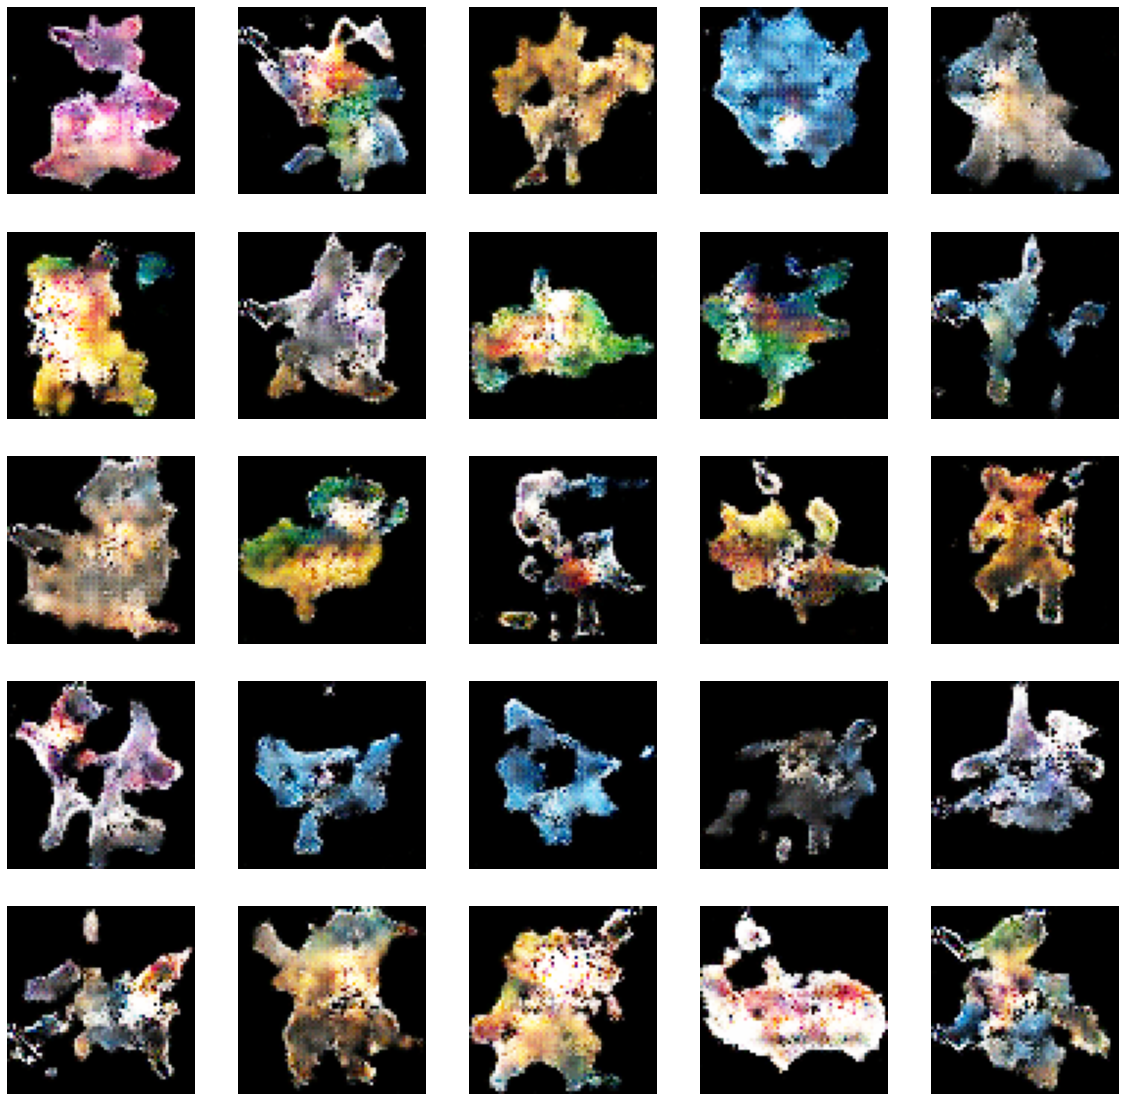

In [31]:
r, c = 5, 5

f = plt.figure(figsize=(20, 20))

seed = np.random.normal(0, 1, (r * c, seed_input_size))
ims = generator_model.predict(seed)

for i in range(r * c):
  f.add_subplot(r, c, i + 1)
  plt.imshow(ims[i])
  plt.axis('off')
plt.show()

In [32]:
generator_model.save("../models/generator.h5")
discriminator_model.save("../models/discriminator.h5")
combined_model.save("../models/combined.h5")